<font size='5'>**Import libraries**</font>

In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import torch.optim as optim 
from PIL import Image
from torch.utils.data import Dataset
import os
from torchvision import tv_tensors
import random
from torchvision.transforms import ColorJitter
from torchvision.transforms import functional as F
import cv2
from torch.utils.data import random_split
import tensorflow as tf
import numpy as np
import copy

import matplotlib.pyplot as plt

<font size='5'>**Configuration**</font>

In [2]:
num_classes = 2  
num_epochs = 10
learning_rate= 1e-4
batch_size=4

<font size='5'>**Dataset**</font>

In [4]:

# Load and transform dataset
class YoloDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, augment=False):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = sorted([file for file in os.listdir(images_dir) if file.endswith(".jpg")])
        self.augment=augment
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        label_path = os.path.join(self.labels_dir, self.image_files[idx].replace(".jpg", ".txt")) 
        
        # Load image
        image = Image.open(img_path).convert("RGB")
        w,h=image.size[0],image.size[1]
        # Load bounding boxes
        boxes = []
        labels = []
        with open(label_path) as f:
            for line in f:
                data = line.strip().split()
                class_id = int(data[0])
                x_center, y_center, width, height = map(float, data[1:])
                labels.append(class_id)
                boxes.append([(x_center-width/2)*w,( y_center-height/2)*h, (x_center+width/2)*w,(y_center+height/2)*h ])
        
        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.tensor(np.reshape(boxes,(0,4)), dtype=torch.float32)
        labels = torch.ones(boxes.shape[0], dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}
        
        if self.augment:
            image,target= self.Data_Augmentations(image,target)
        
        # Apply transformation
        if self.transform:
            image = self.transform(image)
        
        return image, target
    

    def Data_Augmentations(self, image, target):
        # Horizontal Flip
        if random.random() < 0.5:
            image = F.hflip(image)
            width = image.size[0]
            target["boxes"][:, [0, 2]] = width - target["boxes"][:, [2, 0]]  # Adjust bounding boxes
            
        # Color Jitter
        if random.random() < 0.5:
            color_jitter = ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1)
            image = color_jitter(image)

        # Random Scaling
        if random.random() < 0.5:
            scale_factor = random.uniform(0.8, 1.2)
            width, height = image.size
            new_width, new_height = int(width * scale_factor), int(height * scale_factor)
            image = F.resize(image, (new_height, new_width))

            # Adjust boxes for new size
            target["boxes"] = target["boxes"] * scale_factor
            
        return image,target
# Usage
dataset = YoloDataset(images_dir="train/images", labels_dir="train/labels", transform=ToTensor(), augment=True)


In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

<font size='5'>**Visualization**</font>

In [6]:
def show(img,boxes):
    boxes=boxes.detach().numpy().astype(np.int32)
    sample=img.permute(1,2,0).numpy().copy()
    
    for box in boxes:
        sample=cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),(220, 0, 0), 3)
    
    plt.imshow(sample);

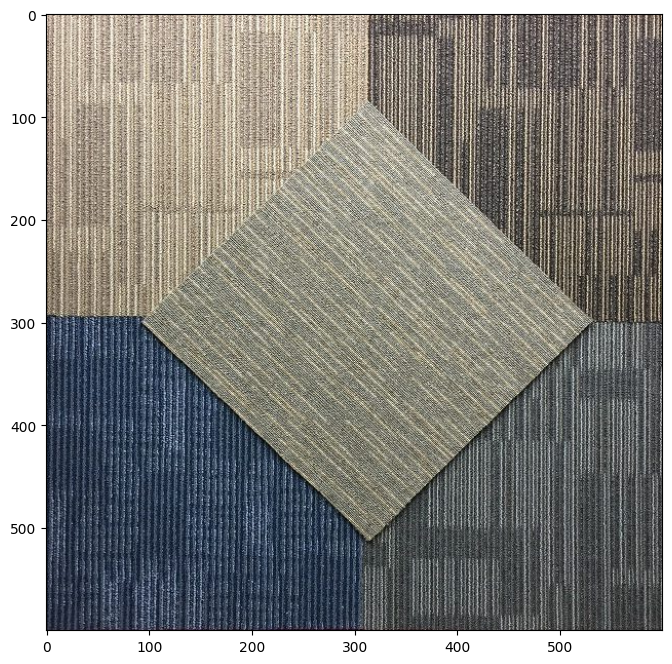

In [6]:
plt.figure(figsize=(8,8))

img,target=next(iter(dataset))
show(img,target["boxes"])

<font size='5'>**Data Loading**</font>

In [7]:
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,collate_fn=collate_fn)

<font size='5'>**Modeling**</font>

In [12]:
# Load a pre-trained Faster R-CNN model and modify it
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)


in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to('cpu')


classification_head=list(model.children())[-2:]
for children in list(model.children())[:-2]:
    for params in children.parameters():
        params.requires_grad=False

parameters=[]
for heads in classification_head:
    for params in heads.parameters():
        parameters.append(params)        



In [26]:
model_weights='Pretrained/TempoRun2024_Model(trial_2).pth'
model.load_state_dict(torch.load(model_weights))
model.to('cpu')

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

<font size='5'>**Training**</font>

In [27]:
# Training
optimizer = torch.optim.Adam(parameters,lr= learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=8, threshold=0.0001)


In [14]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [15]:

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())


In [32]:
for epoch in range(num_epochs):
    training_loss=0.0
    validation_loss=0.0
    current_lr=get_lr(optimizer)
    
    model.train()
    for images, targets in train_loader:
        images = [image.to('cpu') for image in images]
        targets = [{k: v.to('cpu') for k, v in t.items()} for t in targets]
        
        loss_dict=model(images,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    with torch.no_grad():
        for images, targets in val_loader:
            images = [image.to('cpu') for image in images]
            targets = [{k: v.to('cpu') for k, v in t.items()} for t in targets]
            
            # Forward pass for validation
            loss_dict=model(images,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()
            
    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)
    
    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")
    print(f"\n{epoch+1}/{num_epochs}")
    print(f"Training Loss: {training_loss/len(train_dataset)}")
    print(f"Validation_loss: {validation_loss/len(val_dataset)}")
    print("\n"+"*"*50)
    


Updating Best Model weights

1/10
Training Loss: 0.01601495034992695
Validation_loss: 0.004774958826601505

**************************************************
Updating Best Model weights

2/10
Training Loss: 0.004731861874461174
Validation_loss: 0.0035351321566849947

**************************************************
Updating Best Model weights

3/10
Training Loss: 0.01952449604868889
Validation_loss: 0.0010251929052174091

**************************************************

4/10
Training Loss: 0.002111198380589485
Validation_loss: 0.0025945825036615133

**************************************************
Updating Best Model weights

5/10
Training Loss: 0.002005270915105939
Validation_loss: 0.0002807006530929357

**************************************************

6/10
Training Loss: 0.012678522616624832
Validation_loss: 0.0008806095574982464

**************************************************

7/10
Training Loss: 0.0006525952485390007
Validation_loss: 0.0005944291478954256

**********

<font size='5'>Save Weights</font>

In [16]:
model_weights='Pretrained/TempoRun2024_Model(trial_1).pth'
torch.save(best_weights,model_weights)

In [21]:
model.load_state_dict(torch.load(model_weights))
model.to('cpu')

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [28]:
imgs,targets=next(iter(train_loader))
model.eval()
output=model([img.to('cpu') for img in imgs])


In [19]:
def show(img,boxes,ax,color=(255,0,0)):
    
    boxes=boxes.detach().cpu().numpy().astype(np.int32)
    sample=img.permute(1,2,0).numpy().copy()
    
    for box in boxes:
        sample = cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),color, 3)
    
    ax.axis("off");
    ax.imshow(sample);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


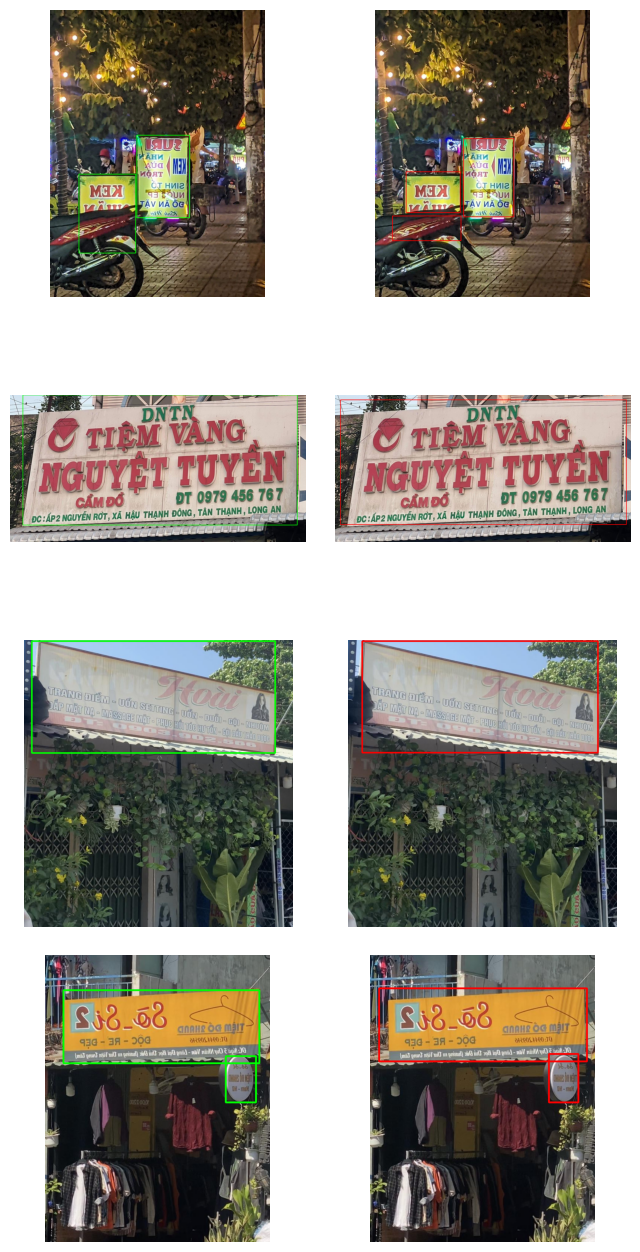

In [30]:
"""During inference, the model requires only the input tensors, and returns the 
   post-processed predictions as a List[Dict[Tensor]], one for each input image. The fields
   of the Dict are as follows:
   - boxes (FloatTensor[N, 4]): the predicted boxes in [x0, y0, x1, y1] format
   - labels (Int64Tensor[N]): the predicted labels for each image
   - scores (Tensor[N]): the scores or each prediction"""
import matplotlib.pyplot as plt
fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    predictions=output[idx]
    
    #real bounding boxes
    show(img,targets[idx]["boxes"],axes[i,0],color=(0,255,0))
    
    #non-max suppression
    #threshold=0.5
    #iou_threshold=0.8
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    pp_boxes=predictions["boxes"][predictions["scores"]>=0.6]
    scores=predictions["scores"][predictions["scores"]>=0.6]
    nms=torchvision.ops.nms(pp_boxes,scores,iou_threshold=0.1)
    pp_boxes=pp_boxes[nms]

    
    show(img,pp_boxes,axes[i,1]);
    

<font size='5'>**Prediction**</font>

In [5]:
import os
f=open('answer.txt','x')

In [26]:
from pathlib import Path
from PIL import Image
from tqdm import tqdm

list_data_test = list(Path("D:\Tempo_Run2024\public_data\images").iterdir())
answer_path = Path("./answer.txt")
answer_path.touch(exist_ok=True)
model.eval()
for img_path in tqdm(list_data_test, desc="Processing images"):
    image= Image.open(img_path).convert("RGB")
    width,height=image.size[0],image.size[1]
    transform= ToTensor()
    image= transform(image).unsqueeze_(0)
    output=model(image)[0]


    pp_boxes=output["boxes"][output["scores"]>=0.4]
    scores=output["scores"][output["scores"]>=0.4]
    nms=torchvision.ops.nms(pp_boxes,scores,iou_threshold=0.05)
    pp_boxes=pp_boxes[nms]
    
    boxes=pp_boxes
    with open(answer_path, "a") as file:
        for bbox in boxes:
            x_min, y_min, x_max, y_max = map(float, bbox.tolist())
            w= x_max-x_min
            h= y_max-y_min
            x = ((x_max+x_min)/2)/width
            y = ((y_max+y_min)/2)/height
            w /= width
            h /= height
            print(x, y, w, h)
            file.write(f"{img_path.stem} 0 {x} {y} {w} {h}\n")
    


<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:5: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Dell\AppData\Local\Temp\ipykernel_20916\3481526962.py:5: SyntaxWarning: invalid escape sequence '\T'
  list_data_test = list(Path("D:\Tempo_Run2024\public_data\images").iterdir())
Processing images:   0%|          | 1/680 [00:03<34:35,  3.06s/it]

0.5181915367042625 0.281423563917144 0.8664037324195754 0.4681769907975397
0.09556941297402374 0.43634953859473474 0.11720685494750785 0.13681081563484768


Processing images:   0%|          | 2/680 [00:06<34:38,  3.07s/it]

0.4900066184710307 0.21641576612317884 0.932109006916184 0.4328315322463577
0.8898593488946018 0.8320266105033256 0.12466660465102598 0.22540118243243243


Processing images:   0%|          | 3/680 [00:10<39:34,  3.51s/it]

0.4917277620023651 0.35147882003889996 0.9235330397727854 0.24480329241071427


Processing images:   1%|          | 4/680 [00:12<35:51,  3.18s/it]

0.5083338591429565 0.29508321677962474 0.9086173323897628 0.5580618658331897
0.8449627300640484 0.6948147146257595 0.061929018862612616 0.5291392054244487


Processing images:   1%|          | 5/680 [00:16<39:29,  3.51s/it]

0.5064805916377476 0.3420405048705544 0.9670913560049874 0.47388767896835776
0.772080625806536 0.6995140937581721 0.4401982171194894 0.20770689300579673


Processing images:   1%|          | 6/680 [00:20<39:58,  3.56s/it]

0.44421525013127755 0.5512898216562823 0.7115548869409121 0.588514167218169


Processing images:   1%|          | 7/680 [00:24<42:04,  3.75s/it]

0.5813500094943577 0.4319418218932843 0.8372999810112848 0.5866822580696007


Processing images:   1%|          | 8/680 [00:28<41:59,  3.75s/it]

0.5345133158365886 0.2985722990464375 0.8778531426323785 0.4809440405374441
0.3282878146701389 0.8162878591118129 0.12242768012152777 0.23106654823249115
0.49799648708767363 0.5975544706304022 0.706142333984375 0.1406513692075761
0.8762063530815972 0.7062749479397532 0.07480908203125 0.10256214908392434
0.0957189432779948 0.7563702558512947 0.07438809543185763 0.39572666610104534
0.06372401258680556 0.37147068357354923 0.03421979437934028 0.2033445930931867


Processing images:   1%|▏         | 9/680 [00:32<42:29,  3.80s/it]

0.5216098971896701 0.40597960754010665 0.7450064425998264 0.5362303056057144
0.39582225206163196 0.7549596246683372 0.6756078830295139 0.08528791703518082


Processing images:   1%|▏         | 10/680 [00:35<41:26,  3.71s/it]

0.5847811957465278 0.4229360753839666 0.8304376085069445 0.4315466169877486
0.11160113694932726 0.8234515103426847 0.1153241475423177 0.33191422895951705


Processing images:   2%|▏         | 11/680 [00:38<39:08,  3.51s/it]

0.4777002766927083 0.1752922338507287 0.6196406792534722 0.2898685689504004
0.31844864230685765 0.3850591040196827 0.4926373291015625 0.11376985170922102


Processing images:   2%|▏         | 12/680 [00:42<38:28,  3.46s/it]

0.4228392469618056 0.32252843165006795 0.7167719184027778 0.5978434222643493


Processing images:   2%|▏         | 13/680 [00:45<37:08,  3.34s/it]

0.516880133734809 0.1958074795263718 0.9566019287109375 0.32274888254272116
0.04574535179138184 0.7537022701613499 0.0844961535135905 0.26148344417055935


Processing images:   2%|▏         | 14/680 [00:48<36:40,  3.30s/it]

0.5145591922573276 0.22911811423027653 0.9270173986474951 0.41248774437155306


Processing images:   2%|▏         | 15/680 [00:51<36:32,  3.30s/it]

0.4185501539607566 0.521050974243846 0.7174598513207395 0.44575021413451466


Processing images:   2%|▏         | 16/680 [00:57<42:45,  3.86s/it]

0.4384493220641779 0.42230933702505585 0.5868856433291993 0.6348251776341229


Processing images:   2%|▎         | 17/680 [01:01<46:13,  4.18s/it]

0.4848400377759747 0.17415542733051675 0.9079054747271902 0.30261452899533864
0.4761834061483412 0.39814579312053244 0.8889647859893334 0.11223544869371639
0.733632854386872 0.475056682747014 0.5009789892790883 0.0680889528634378
0.38168256838596987 0.6498926186957783 0.07453439749923407 0.28849462842894674


Processing images:   3%|▎         | 18/680 [01:06<47:24,  4.30s/it]

0.5098277311171254 0.20193095215421536 0.9137831157253634 0.36457197350191783
0.36770469911636844 0.6967504767255406 0.0847612811673072 0.3724639945104077


Processing images:   3%|▎         | 19/680 [01:09<44:23,  4.03s/it]

0.5155897111457012 0.44700037065099496 0.8607143653830901 0.4304691533573338


Processing images:   3%|▎         | 20/680 [01:15<50:23,  4.58s/it]

0.5073446872386527 0.30221913360820807 0.8949876846151149 0.37042405959552405


Processing images:   3%|▎         | 21/680 [01:20<50:19,  4.58s/it]

0.47472308499969706 0.40306694130059695 0.8806920100302592 0.5554562566595843


Processing images:   3%|▎         | 22/680 [01:24<49:08,  4.48s/it]

0.4128349400099429 0.5327703704833985 0.5074501996599762 0.5202195129394531


Processing images:   3%|▎         | 23/680 [01:29<48:45,  4.45s/it]

0.4950434686250552 0.5326540837522413 0.43589341958613376 0.5170456683049437


Processing images:   4%|▎         | 24/680 [01:35<55:12,  5.05s/it]

0.47346825839420936 0.24310486772087184 0.855064186081984 0.3541881314824136
0.36150465064874576 0.46694663401400105 0.6493603903488074 0.1223926329880618


Processing images:   4%|▎         | 25/680 [01:40<55:27,  5.08s/it]

0.3848311502425397 0.5699656350272042 0.34251511370549437 0.4449179149809338


Processing images:   4%|▍         | 26/680 [01:45<54:10,  4.97s/it]

0.4813747355143229 0.593016644971422 0.5655502251519097 0.47661731413239666


Processing images:   4%|▍         | 27/680 [01:49<51:58,  4.78s/it]

0.4987115953233507 0.33474106579521984 0.7863099907769098 0.24859587096225486
0.06041666920979818 0.6801664506748475 0.08459091016981336 0.4664999176647429
0.9075129665798611 0.08320753569953451 0.17283626302083333 0.14584101417169223
0.41004246817694767 0.15040337678604174 0.7955818388197157 0.09624684306115851


Processing images:   4%|▍         | 28/680 [01:53<47:43,  4.39s/it]

0.44518547397189673 0.2273208945605888 0.7837422247992621 0.11851604936460569
0.1747353786892361 0.5311396128118294 0.08431301540798611 0.3651762213318133


Processing images:   4%|▍         | 29/680 [01:56<45:07,  4.16s/it]

0.6121700981987848 0.6848611980813736 0.3516244303385417 0.12471290455022424
0.1443828885820177 0.7263864132934683 0.2754138018290202 0.1133285283823022
0.7019918484157986 0.39034302122788134 0.5344002007378472 0.3989381202339797
0.7927904188368056 0.8780088872128708 0.1872943793402778 0.18782943262347632
0.9468071560329862 0.8803196883355134 0.09465999348958333 0.23915578777239535


Processing images:   4%|▍         | 30/680 [02:03<52:58,  4.89s/it]

0.49915256076388886 0.38604196390711276 0.9983051215277777 0.6632876432031617


Processing images:   5%|▍         | 31/680 [02:10<59:15,  5.48s/it]

0.43005280115614375 0.4659698297589535 0.6755023248691107 0.7014187305570216


Processing images:   5%|▍         | 32/680 [02:16<1:00:22,  5.59s/it]

0.4961277126736111 0.4578756218282585 0.9922554253472222 0.7466132269965278


Processing images:   5%|▍         | 33/680 [02:20<56:27,  5.24s/it]  

0.6932108561197917 0.36115654309590656 0.59274560546875 0.7223130861918131
0.536085693359375 0.875707573360867 0.049476399739583336 0.18748463524712455


Processing images:   5%|▌         | 34/680 [02:24<53:32,  4.97s/it]

0.5308320176866319 0.24925093397246878 0.9244177788628473 0.49850186794493756
0.7610324164496528 0.6066198682970574 0.27907329644097223 0.2820999006971466
0.38362579006618924 0.6734326235205902 0.5459630466037326 0.2561955037593223


Processing images:   5%|▌         | 35/680 [02:29<53:04,  4.94s/it]

0.5073985550514825 0.3103582362143989 0.9852027660934727 0.567402981891231


Processing images:   5%|▌         | 36/680 [02:35<56:07,  5.23s/it]

0.10529375509483176 0.7295594411969044 0.20833281551683946 0.5351954304006552
0.5039985440911343 0.20811164505490146 0.9895646499732051 0.26550942680439765
0.9083055708533377 0.674931700294234 0.15154276885565202 0.5766611986643294


Processing images:   5%|▌         | 37/680 [02:40<56:07,  5.24s/it]

0.6310361599392361 0.4756555760160406 0.6617328016493056 0.3713945197479341


Processing images:   6%|▌         | 38/680 [02:44<50:40,  4.74s/it]

0.5367535061306423 0.5322081382551201 0.7125251057942709 0.1744006978163368
0.4701291232638889 0.23650544866679787 0.8715961371527777 0.4082667829624987
0.07575748189290364 0.6836861813098671 0.14429612562391492 0.11881281297959885


Processing images:   6%|▌         | 39/680 [02:48<49:37,  4.65s/it]

0.4881095905303955 0.44860928946167883 0.9670247425503201 0.5934595261177007
0.9038311360677084 0.8609912064823791 0.13535422092013888 0.1990383918558014
0.9160263400607639 0.13930927053855283 0.1569540473090278 0.23878167609518752


Processing images:   6%|▌         | 40/680 [02:52<45:54,  4.30s/it]

0.4761737636990017 0.33104503532651525 0.8306578979492187 0.5360917266347337
0.854982177734375 0.7289872549681796 0.13029454210069444 0.16920375915585975
0.1464999796549479 0.685451276707718 0.06719502766927084 0.15790416413379563


Processing images:   6%|▌         | 41/680 [02:56<46:22,  4.35s/it]

0.6451612955729167 0.2784406444694422 0.6070011935763889 0.21763591524920886


Processing images:   6%|▌         | 42/680 [03:01<46:34,  4.38s/it]

0.4553901375114144 0.4716094287473764 0.6871227578167275 0.431200245719644


Processing images:   6%|▋         | 43/680 [03:06<49:38,  4.68s/it]

0.5840329842656931 0.5022404336521769 0.5602775144193511 0.37152960361578524
0.8476528546126215 0.8934215643467047 0.304694290774757 0.1869875263964009


Processing images:   6%|▋         | 44/680 [03:14<1:00:33,  5.71s/it]

0.6645066324869792 0.4097846782312984 0.621484130859375 0.15139065632777932


Processing images:   7%|▋         | 45/680 [03:19<56:35,  5.35s/it]  

0.46180629054544425 0.2909550948005399 0.8839570385241798 0.4412746692690975
0.9411495996390277 0.7996670137833771 0.102587309926145 0.3931881319474396
0.975921661747612 0.3066197566435657 0.048156676504776064 0.25184009126019447


Processing images:   7%|▋         | 46/680 [03:22<51:01,  4.83s/it]

0.5719390258789062 0.5266034669965227 0.7050327555338541 0.7472473215834002
0.9426253255208333 0.666043415247837 0.10896875 0.5714743427027051


Processing images:   7%|▋         | 47/680 [03:27<51:19,  4.86s/it]

0.49296079593234593 0.49276954309264226 0.9640714636908637 0.8765670093137826


Processing images:   7%|▋         | 48/680 [03:32<50:17,  4.77s/it]

0.4635362555127625 0.2222737390167859 0.8875470327674796 0.31715437830710896
0.6086025413023223 0.5270941403447366 0.6986017909618693 0.14753509054378589
0.812567138671875 0.7775577233762158 0.07781612851204128 0.3503085545131138


Processing images:   7%|▋         | 49/680 [03:38<53:00,  5.04s/it]

0.47073764300971443 0.28292977084788673 0.9414752860194289 0.4606981764744668
0.8788916198501873 0.7619027836189363 0.12221752838249064 0.4585794787627357
0.9417316565352879 0.17414465669877918 0.08792422862535113 0.17636721905710634


Processing images:   7%|▋         | 50/680 [03:43<54:32,  5.19s/it]

0.4774038897620307 0.26248957168224246 0.9422855364481608 0.36813247148380723


Processing images:   8%|▊         | 51/680 [03:47<50:29,  4.82s/it]

0.4748706891269758 0.39576794677998595 0.8591887720763454 0.7048248522209398


Processing images:   8%|▊         | 52/680 [03:51<47:50,  4.57s/it]

0.5026966315858504 0.2907796647813585 0.9134726138675914 0.5703029208713107
0.09957358591696795 0.7557910834418403 0.13569674421759212 0.4884178331163194
0.9762038062600529 0.4897899881998698 0.04644640754250919 0.21964107937282987
0.9054365719065947 0.8138184950086805 0.07412944120519302 0.3723630099826389


Processing images:   8%|▊         | 53/680 [03:55<46:02,  4.41s/it]

0.4866745303926014 0.2843518858689528 0.8733312080019996 0.39474950350247895
0.45552353722708566 0.5204540546123798 0.8984423228672572 0.10795626126802885
0.29003460475376674 0.7610021503155048 0.3794818623860677 0.3831219012920673


Processing images:   8%|▊         | 54/680 [03:59<44:32,  4.27s/it]

0.5022641252880254 0.2529475775948406 0.9450930288015318 0.35568446138479415
0.8631441731098269 0.5080795473715974 0.18247809291871125 0.19728730658835159


Processing images:   8%|▊         | 55/680 [04:03<42:24,  4.07s/it]

0.5077482198079427 0.29182577820263955 0.9105960083007812 0.557458089705732
0.5637120903862847 0.6617059918347743 0.7601513400607639 0.11657163709774256


Processing images:   8%|▊         | 56/680 [04:07<42:32,  4.09s/it]

0.4923760257871811 0.2837786474300705 0.9156966430319231 0.49682885453901215
0.4727953894663665 0.815216064453125 0.13157372771009887 0.19540079131381202
0.54370412880418 0.5820632235694477 0.8303494555801995 0.10684891329466842


Processing images:   8%|▊         | 57/680 [04:12<46:24,  4.47s/it]

0.49801191148303803 0.27186230029240166 0.990069462004162 0.5437246005848033
0.5786353883289156 0.605050559935531 0.7704756600516183 0.173907272214812


Processing images:   9%|▊         | 58/680 [04:19<55:19,  5.34s/it]

0.4786316619336026 0.27074872139961487 0.9426932404342206 0.46466189046059886
0.5617834433768559 0.6043322163243448 0.8764331132462881 0.09283949329007056
0.06242405789569744 0.7851553886167465 0.12484811579139488 0.42968922276650706


Processing images:   9%|▊         | 59/680 [04:25<55:20,  5.35s/it]

0.48065930889587843 0.2448336771813688 0.9242638713544081 0.33044459057094466


Processing images:   9%|▉         | 60/680 [04:29<50:15,  4.86s/it]

0.3925660626799548 0.851813612656556 0.19772952515967324 0.29637277468688805
0.5229692905604625 0.2692703789892769 0.8891862500615481 0.43397262513481916


Processing images:   9%|▉         | 61/680 [04:32<45:46,  4.44s/it]

0.5158212252673561 0.5445977487871724 0.45708922945559793 0.8082025934034778


Processing images:   9%|▉         | 62/680 [04:39<54:05,  5.25s/it]

0.5020332729693541 0.4042634976755982 0.8406171031833924 0.5167478998023344
0.6521437497483087 0.7340516444031334 0.6445827838071843 0.13442319081011547
0.17151480999189553 0.8792559561161312 0.11909485649816769 0.19327783137759372
0.1529505778833763 0.07252682707555483 0.06856041347857603 0.14505365415110966


Processing images:   9%|▉         | 63/680 [04:43<50:06,  4.87s/it]

0.49761364161591465 0.4831043204875908 0.8857802428427598 0.5312124695440735
0.5414423309596239 0.13450630024226026 0.15389949060722188 0.23389951628868025


Processing images:   9%|▉         | 64/680 [04:47<47:15,  4.60s/it]

0.4839540021684435 0.2766563626350029 0.9573157369825576 0.5162991751470953
0.5189682074652778 0.8411146687019356 0.10678342013888889 0.2262512779832508


Processing images:  10%|▉         | 65/680 [04:52<46:34,  4.54s/it]

0.54133428935132 0.6179431320571571 0.8358292756257234 0.1838973486454296
0.4066156665743826 0.20574593194900762 0.7058926168869784 0.3464489098153784


Processing images:  10%|▉         | 66/680 [04:57<49:38,  4.85s/it]

0.46814270317554474 0.199633688987718 0.8409120227609362 0.35924451573457317
0.5088159101349967 0.5523171433583038 0.8410739728382656 0.07273912168290105
0.8477531501225063 0.8219488447283478 0.1351137842450823 0.21890632587551417


Processing images:  10%|▉         | 67/680 [05:02<48:32,  4.75s/it]

0.49457962062501687 0.1996193386205641 0.9341123950096869 0.3985155895540986
0.31112151431597873 0.7572498434203586 0.12654210455406645 0.15511181022547468


Processing images:  10%|█         | 68/680 [05:06<47:13,  4.63s/it]

0.47598421785843936 0.3042831283274705 0.9159859981836449 0.5961261063087278
0.5166398412894204 0.7055483934355945 0.9116016727467482 0.15792424892022358
0.963023879765216 0.9160059983168191 0.07310746277814135 0.1679880033663618
0.07471394988254727 0.9554484049479167 0.13563778812348531 0.08910319010416666


Processing images:  10%|█         | 69/680 [05:12<51:16,  5.04s/it]

0.4351351972411527 0.4492364108882351 0.39625775102783783 0.6844656574065016


Processing images:  10%|█         | 70/680 [05:18<52:47,  5.19s/it]

0.5077070847997126 0.216788646083972 0.8734426534400797 0.300265487458165
0.054601402440161075 0.9350316733008555 0.10667328857026011 0.12993665339828897


Processing images:  10%|█         | 71/680 [05:25<58:56,  5.81s/it]

0.4820434796648061 0.36324768862171 0.51094762474409 0.3661415866021227
0.42226567403937154 0.6902042871348395 0.2937694120466046 0.22193250196076433


Processing images:  11%|█         | 72/680 [05:31<59:37,  5.88s/it]

0.5042510413935248 0.2391857347990337 0.869841414637062 0.35694879517519384
0.2240417683818851 0.8807884273672463 0.19780560989605828 0.2384231452655075
0.5745305233623057 0.5324718274568256 0.810608753682595 0.12864233031308742
0.09155888948129878 0.6617523422814849 0.1334190067392935 0.2887460350093985


Processing images:  11%|█         | 73/680 [05:37<1:00:53,  6.02s/it]

0.50304985973284 0.3367439799991944 0.9538687320816337 0.522340556474567
0.5017164819441398 0.6195402021173458 0.6944778145775682 0.08420303278480011
0.8944768720260192 0.6538778213964702 0.13469799857417655 0.10153622220118036


Processing images:  11%|█         | 74/680 [05:41<53:48,  5.33s/it]  

0.4999852711325809 0.31629988737589315 0.9146847018660096 0.5397076232667712
0.5420434144898052 0.641646293329506 0.9159131710203896 0.08879748498789722
0.7983523402994162 0.07959118239810947 0.11289288205998911 0.13429248605252733


Processing images:  11%|█         | 75/680 [05:45<49:15,  4.89s/it]

0.4424387863959266 0.1540596851783302 0.7548891631851482 0.3081193703566604
0.49288942617423526 0.41353307202371675 0.9564734317836691 0.2404706008416459
0.772952047626624 0.7637226107907316 0.11154283387830641 0.3447965778912095


Processing images:  11%|█         | 76/680 [05:48<45:28,  4.52s/it]

0.5298758544921875 0.27756625951955866 0.7887135687934028 0.2864675563641748


Processing images:  11%|█▏        | 77/680 [05:55<51:50,  5.16s/it]

0.4848418394724528 0.3324341308459089 0.24781370162963867 0.3475422425225369


Processing images:  11%|█▏        | 78/680 [05:59<46:51,  4.67s/it]

0.5051621710166483 0.23363341230244428 0.7998019582856961 0.35595995437662903


Processing images:  12%|█▏        | 79/680 [06:05<53:00,  5.29s/it]

0.34153502061631946 0.3439333924679173 0.6830700412326389 0.26132039515576017
0.8721703287760416 0.6850476638650446 0.07139729817708333 0.2350427992291585


Processing images:  12%|█▏        | 80/680 [06:11<55:35,  5.56s/it]

0.4930947863790724 0.1665702874515219 0.9848972327974107 0.30410594324911794
0.26663687472873265 0.7879137155402945 0.22458296712239584 0.3561590598048275
0.05320862833658854 0.7417386509611615 0.10641725667317709 0.11760741749971998
0.07153705151875814 0.354153308389862 0.1313376808166504 0.2367156927730875


Processing images:  12%|█▏        | 81/680 [06:17<56:42,  5.68s/it]

0.5017508578830295 0.32675504416562196 0.8986671210394965 0.48274695471431434


Processing images:  12%|█▏        | 82/680 [06:21<50:24,  5.06s/it]

0.40277794053819443 0.4375033478032213 0.7092455512152778 0.1835226437662908


Processing images:  12%|█▏        | 83/680 [06:29<58:53,  5.92s/it]

0.4040738189844389 0.40533882510819624 0.756178372490833 0.35419282619123416


Processing images:  12%|█▏        | 84/680 [06:35<58:55,  5.93s/it]

0.5069587430087003 0.47558660631055955 0.8308086325905539 0.502137667172915


Processing images:  12%|█▎        | 85/680 [06:40<55:29,  5.60s/it]

0.36899260881726176 0.5869752818669831 0.7108280812365436 0.38994513958752514
0.5077964979378539 0.26165003939653547 0.9031059548563809 0.2276008959027603


Processing images:  13%|█▎        | 86/680 [06:45<54:37,  5.52s/it]

0.49776609234294594 0.1595357898813988 0.9955321846858919 0.24306584383672758
0.43764230194876985 0.5001993198903923 0.8444948627173117 0.44223558241826555


Processing images:  13%|█▎        | 87/680 [06:51<56:35,  5.73s/it]

0.6472345135965825 0.3558071808703639 0.679515374697037 0.4214685849070296
0.16650143781349494 0.6371814865468667 0.2104055851957786 0.3783573547492868


Processing images:  13%|█▎        | 88/680 [06:58<58:57,  5.97s/it]

0.504166258070204 0.2273872714230319 0.9084756435818142 0.297543992428438


Processing images:  13%|█▎        | 89/680 [07:04<58:58,  5.99s/it]

0.5326456327265924 0.1956016731262207 0.8742759502978583 0.3895559310913086
0.3249318808607332 0.748165283203125 0.6498637617214664 0.18151340060763888
0.8913653589919811 0.9024436848958334 0.20002052614851357 0.06747330729166667


Processing images:  13%|█▎        | 90/680 [07:09<56:53,  5.79s/it]

0.5111555142569101 0.24976527725541314 0.9241562516292752 0.47767050806866135
0.4895877710847639 0.6660972639571788 0.9602978861062679 0.29018504120582755


Processing images:  13%|█▎        | 91/680 [07:14<54:33,  5.56s/it]

0.4858709092573686 0.3997723697109982 0.6452929826216264 0.41538359379745204


Processing images:  14%|█▎        | 92/680 [07:18<48:39,  4.97s/it]

0.5163032210016825 0.4851433254317614 0.7780823581189994 0.6808316955210308


Processing images:  14%|█▎        | 93/680 [07:22<46:32,  4.76s/it]

0.5635526270454769 0.5138903263300258 0.8393340531653507 0.8424000214597347


Processing images:  14%|█▍        | 94/680 [07:27<47:28,  4.86s/it]

0.5185405178425815 0.3778374382093841 0.7208395236875953 0.46131213506062824


Processing images:  14%|█▍        | 95/680 [07:35<54:36,  5.60s/it]

0.5285931781486228 0.4221593376457126 0.9428136437027542 0.4275795039185985
0.8871778982656974 0.7170941078499572 0.22564420346860534 0.10596468476274368


Processing images:  14%|█▍        | 96/680 [07:42<59:18,  6.09s/it]

0.486621717127358 0.20523544760311352 0.973243434254716 0.2534270970961627


Processing images:  14%|█▍        | 97/680 [07:45<52:18,  5.38s/it]

0.5219124091701219 0.30753224641229765 0.9142142998142531 0.4246126377362007


Processing images:  14%|█▍        | 98/680 [07:50<50:33,  5.21s/it]

0.29209002591757627 0.5047297859856475 0.30752453454560985 0.3893634915767231


Processing images:  15%|█▍        | 99/680 [07:55<48:54,  5.05s/it]

0.5216413277408932 0.619292373342396 0.4499336397264228 0.24515488321548315


Processing images:  15%|█▍        | 100/680 [07:59<46:15,  4.78s/it]

0.49361644625129186 0.5405797745949498 0.8977318494309224 0.4156603259749597


Processing images:  15%|█▍        | 101/680 [08:03<43:52,  4.55s/it]

0.5700850994266264 0.5133208909738695 0.5336772004066155 0.4445038904386643


Processing images:  15%|█▌        | 102/680 [08:07<41:58,  4.36s/it]

0.5262986721462674 0.4556729969684168 0.820317152235243 0.24502356617122048
0.04988312419255574 0.8474397913518065 0.09899896971384685 0.21546186460217537


Processing images:  15%|█▌        | 103/680 [08:12<43:45,  4.55s/it]

0.5280160420735677 0.2237570235308479 0.9228455200195312 0.3452988837747013
0.43570735677083333 0.7270138729319853 0.570666015625 0.37162798713235295
0.401154290093316 0.4403826904296875 0.6296869710286458 0.09382489372702206


Processing images:  15%|█▌        | 104/680 [08:17<43:37,  4.54s/it]

0.6191940104166667 0.40226505265567764 0.7185796440972222 0.6794324043469552


Processing images:  15%|█▌        | 105/680 [08:23<50:12,  5.24s/it]

0.5129539693196614 0.39612574200188727 0.8500252210828994 0.23953125449063076
0.5066100667317708 0.6501323388881438 0.818106689453125 0.20249361731683016


Processing images:  16%|█▌        | 106/680 [08:28<47:12,  4.93s/it]

0.5286228942871094 0.3467815735500539 0.8911172756618924 0.4042842803034594
0.44054121907552085 0.8796006488136239 0.4568793674045139 0.1146755705300174


Processing images:  16%|█▌        | 107/680 [08:34<52:30,  5.50s/it]

0.6286388210720486 0.453259556169012 0.6625858561197917 0.6281946123524044
0.1499242418077257 0.6460822538199674 0.20286614312065973 0.4115213294584588


Processing images:  16%|█▌        | 108/680 [08:41<56:32,  5.93s/it]

0.45583973524305554 0.48960986043221216 0.9116794704861111 0.59882024631466
0.8456825900607639 0.8741288518991248 0.3016387261284722 0.1761592954022666


Processing images:  16%|█▌        | 109/680 [08:49<1:01:08,  6.42s/it]

0.4796191236707899 0.41665375801749444 0.8612849731445312 0.3252169213359184


Processing images:  16%|█▌        | 110/680 [08:54<57:09,  6.02s/it]  

0.11092662212738931 0.7768224530515417 0.1546858823449043 0.41805836725375645
0.5799598374626128 0.5516546918930909 0.7936406155510427 0.22970256974211836
0.6929443870129446 0.3243076695805102 0.5245453263925209 0.19139288168037888


Processing images:  16%|█▋        | 111/680 [08:59<54:46,  5.78s/it]

0.4364456946055094 0.40843212604522705 0.8593739102681478 0.3664664109547933


Processing images:  16%|█▋        | 112/680 [09:03<49:53,  5.27s/it]

0.5014332054985894 0.4505214160208528 0.9420613233778212 0.4854098203605962


Processing images:  17%|█▋        | 113/680 [09:07<45:35,  4.83s/it]

0.5147288648817274 0.38715252766336367 0.9636718275282118 0.5822177108386762


Processing images:  17%|█▋        | 114/680 [09:13<49:05,  5.20s/it]

0.5310091417100694 0.17402122497558595 0.9189465603298611 0.328785400390625
0.5280936143663194 0.4318238830566406 0.9438127712673611 0.23765869140625


Processing images:  17%|█▋        | 115/680 [09:18<47:24,  5.04s/it]

0.5095861070421007 0.3551095225531527 0.9170526123046875 0.4503542048541233


Processing images:  17%|█▋        | 116/680 [09:23<47:55,  5.10s/it]

0.48021776665581595 0.4471843223510546 0.7417132297092014 0.6490283310891729
0.8128275282118056 0.8409130163789752 0.07577571614583334 0.31817396724204955


Processing images:  17%|█▋        | 117/680 [09:31<56:34,  6.03s/it]

0.494436755710178 0.32407659022652324 0.918808129204644 0.3076642892896402


Processing images:  17%|█▋        | 118/680 [09:37<55:49,  5.96s/it]

0.4545307193332248 0.2805370807647705 0.8285703972710503 0.3368738038199289
0.44702227952745227 0.6210365976606097 0.8706072421603732 0.35202960968017577


Processing images:  18%|█▊        | 119/680 [09:44<59:22,  6.35s/it]

0.5124111056857639 0.28777213754325076 0.9182060004340278 0.45080958289661627
0.043725060356987845 0.2934260587582643 0.08745012071397569 0.35726905691212624


Processing images:  18%|█▊        | 120/680 [09:53<1:05:18,  7.00s/it]

0.5091390262179905 0.3151200006207271 0.9074220343695747 0.3864545800997783


Processing images:  18%|█▊        | 121/680 [09:57<57:42,  6.19s/it]  

0.5143541378445096 0.23871072215951367 0.9612956305609809 0.30917396710548567
0.07634358215332031 0.5862054866113704 0.14176802232530383 0.3018303941338609


Processing images:  18%|█▊        | 122/680 [10:02<53:23,  5.74s/it]

0.4434365980360243 0.279478139035842 0.8026821424696181 0.5116483828600715
0.23472345987955728 0.7503288717830883 0.30664661322699654 0.42071030560661765


Processing images:  18%|█▊        | 123/680 [10:06<48:56,  5.27s/it]

0.5806125217013889 0.34016100183576986 0.8164049479166666 0.47901527503017705
0.29556410047743054 0.7901854420936159 0.1384240451388889 0.25342446519581546
0.8612543674045139 0.8293780805726931 0.08307785373263889 0.2099869232832618
0.5137664659288195 0.7059873916560488 0.08238753255208334 0.32031318107899676


Processing images:  18%|█▊        | 124/680 [10:16<1:00:41,  6.55s/it]

0.500299555460612 0.4908293586621846 0.908660871717665 0.42255583743188774


Processing images:  18%|█▊        | 125/680 [10:22<59:18,  6.41s/it]  

0.5699769304441874 0.43954801920937475 0.5217535239445994 0.7270788853945689


Processing images:  19%|█▊        | 126/680 [10:28<1:00:16,  6.53s/it]

0.5021065508524577 0.36303197517227465 0.9928795632256402 0.637224001905405
0.9752763129340277 0.8609097258761896 0.049447374131944444 0.06594531392981333


Processing images:  19%|█▊        | 127/680 [10:38<1:07:55,  7.37s/it]

0.4557555980896682 0.3274840707400096 0.9115111961793364 0.613694174507945


Processing images:  19%|█▉        | 128/680 [10:44<1:04:55,  7.06s/it]

0.5846531846788194 0.30251864729256467 0.7345287000868056 0.1953813319669622


Processing images:  19%|█▉        | 129/680 [10:55<1:16:15,  8.30s/it]

0.4913105706108941 0.3591998350214411 0.8702462632921006 0.5771197985772188


Processing images:  19%|█▉        | 130/680 [11:01<1:09:41,  7.60s/it]

0.6284883897569444 0.4661969953569873 0.7158001302083333 0.8107921707219091


Processing images:  19%|█▉        | 131/680 [11:08<1:07:16,  7.35s/it]

0.4754872127109104 0.21657724131252284 0.9367451926337348 0.3343432976094368


Processing images:  19%|█▉        | 132/680 [11:14<1:04:19,  7.04s/it]

0.4666988754795739 0.49227751766342714 0.45713841735253774 0.6185732002717903
0.11927746156606164 0.5157531370599586 0.21540259137565707 0.19443043168768825


Processing images:  20%|█▉        | 133/680 [11:21<1:03:30,  6.97s/it]

0.17440364922417534 0.3669906131438516 0.18051187472873265 0.39917689336410267
0.4974195285373264 0.4901696809661911 0.5216824273003472 0.7189155844083893


Processing images:  20%|█▉        | 134/680 [11:30<1:07:25,  7.41s/it]

0.5606373765733507 0.36772606455681406 0.8787252468532986 0.4816347610689652
0.9377610134548611 0.6507207215062439 0.10628483072916667 0.1248152056562701


Processing images:  20%|█▉        | 135/680 [11:36<1:05:40,  7.23s/it]

0.7031156277126737 0.4595292115596921 0.5246548122829862 0.7165452018896371
0.2359815199110243 0.6455139442073831 0.3905516628689236 0.23220127449299943


Processing images:  20%|██        | 136/680 [11:41<57:45,  6.37s/it]  

0.5231434427897136 0.26924662410464745 0.9295750935872396 0.2312612653277409
0.2223121066623264 0.6844521047679949 0.15975887044270834 0.22546584636097672


Processing images:  20%|██        | 137/680 [11:44<50:14,  5.55s/it]

0.48165802001953123 0.22918706887388882 0.9122727186414931 0.3534755870087506
0.15812210422092013 0.6972941829733652 0.24092245822482639 0.462994248899695
0.8183417426215278 0.6639220877869488 0.18827745225694445 0.3760668610873288


Processing images:  20%|██        | 138/680 [11:51<52:22,  5.80s/it]

0.5 0.49327897090537876 1.0 0.43176714579264325


Processing images:  20%|██        | 139/680 [11:58<55:33,  6.16s/it]

0.5 0.16539065562440744 1.0 0.1713636792248578
0.09091446868217003 0.6081161053901236 0.10749631514276908 0.12007762503874343


Processing images:  21%|██        | 140/680 [12:04<55:17,  6.14s/it]

0.4816804817806987 0.16855278777152516 0.9261248624335705 0.31915033585222813
0.09944400543045365 0.4895165284089834 0.18436837610801424 0.34895568552086487
0.5807158320951331 0.40917360984672935 0.8304768498622269 0.13505620702415633
0.08368941129944461 0.7817566435215837 0.08097551769874342 0.10833910186989255


Processing images:  21%|██        | 141/680 [12:07<47:50,  5.33s/it]

0.5164989648041902 0.2220195449137445 0.8624619589911566 0.16759562249761506
0.9400666978624131 0.4065590010650945 0.11986660427517361 0.1112667793041021


Processing images:  21%|██        | 142/680 [12:12<45:03,  5.03s/it]

0.49566746929868183 0.19111228364390537 0.9540864785812753 0.32929796210686024


Processing images:  21%|██        | 143/680 [12:17<45:29,  5.08s/it]

0.3800123291015625 0.23236278628884088 0.6959949815538194 0.4134853413303984


Processing images:  21%|██        | 144/680 [12:22<46:44,  5.23s/it]

0.47983772956000437 0.1914095935878811 0.9012043151855469 0.32565161272570176


Processing images:  21%|██▏       | 145/680 [12:26<43:13,  4.85s/it]

0.5118603888617621 0.4273969308346446 0.9472208455403646 0.7840837927667935


Processing images:  21%|██▏       | 146/680 [12:33<46:49,  5.26s/it]

0.4990457102457682 0.4036474584049209 0.9132310621473524 0.4145980982694718


Processing images:  22%|██▏       | 147/680 [12:37<43:24,  4.89s/it]

0.51742193548529 0.20763938947122268 0.91820568737683 0.3657740077059731


Processing images:  22%|██▏       | 148/680 [12:40<39:56,  4.51s/it]

0.49637806532118056 0.17631825278787053 0.9197052408854167 0.3323642506318934
0.08499121348063152 0.698737621307373 0.13917924838595921 0.6025247573852539
0.5131249084472657 0.3886440641739789 0.9525887247721354 0.10278609219719381


Processing images:  22%|██▏       | 149/680 [12:46<43:50,  4.95s/it]

0.6332042507595486 0.43160191664459013 0.720225830078125 0.45404662815391594
0.957091796875 0.7383890084341063 0.05978450520833333 0.20008725646539782


Processing images:  22%|██▏       | 150/680 [12:50<40:20,  4.57s/it]

0.5055793050130208 0.309041949535938 0.9814763726128473 0.6050334130956772


Processing images:  22%|██▏       | 151/680 [12:54<39:50,  4.52s/it]

0.492720086839464 0.28735195485269477 0.9513985850016276 0.47229180259374515
0.8243342827690973 0.7249276971050777 0.35133143446180554 0.27964267801442755


Processing images:  22%|██▏       | 152/680 [13:01<45:01,  5.12s/it]

0.5473069797092014 0.44037001577167 0.8101861707899306 0.6989140190250218
0.3472593994140625 0.8377297985236455 0.23781334092881945 0.10380463304024082


Processing images:  22%|██▎       | 153/680 [13:08<50:50,  5.79s/it]

0.45559790722033794 0.5807738418376012 0.606861254986555 0.5863477678138171
0.4852171427973945 0.1468425300550757 0.9662089744640815 0.10034889146725266


Processing images:  23%|██▎       | 154/680 [13:12<44:35,  5.09s/it]

0.5164032524956598 0.29872902717379574 0.9671934950086806 0.2999227955855059


Processing images:  23%|██▎       | 155/680 [13:16<42:22,  4.84s/it]

0.41474249013264974 0.49010447067319207 0.7775406273735894 0.7295768416247606


Processing images:  23%|██▎       | 156/680 [13:20<39:35,  4.53s/it]

0.5568513522677951 0.4782290437296367 0.8781241183810764 0.5044011342685853


Processing images:  23%|██▎       | 157/680 [13:27<46:10,  5.30s/it]

0.5418174811469184 0.44519267685111913 0.8997975463867187 0.33673233821474274


Processing images:  23%|██▎       | 158/680 [13:32<45:22,  5.21s/it]

0.504756606180608 0.5230149217480607 0.8459789453868798 0.8240760411971655


Processing images:  23%|██▎       | 159/680 [13:37<44:04,  5.08s/it]

0.4327210849530912 0.4023062298406704 0.59386692117849 0.53097625352535


Processing images:  24%|██▎       | 160/680 [13:41<42:34,  4.91s/it]

0.48766262190682547 0.4637880731136241 0.7967482789770349 0.8132078337613009
0.7628342021595348 0.9125025323096742 0.440995303067294 0.14045971448821662


Processing images:  24%|██▎       | 161/680 [13:45<40:05,  4.64s/it]

0.48517676213557975 0.44101619640385575 0.9247688831098928 0.7820899636679393


Processing images:  24%|██▍       | 162/680 [13:52<45:35,  5.28s/it]

0.4803594385782878 0.3027814671613168 0.9259542999267578 0.4858033332271852
0.3422245279947917 0.5961431752080503 0.6844490559895834 0.17545506574105527


Processing images:  24%|██▍       | 163/680 [13:56<42:40,  4.95s/it]

0.6594490435483644 0.43013234172917447 0.6425487710417603 0.8131184577941895


Processing images:  24%|██▍       | 164/680 [14:00<40:51,  4.75s/it]

0.48903733533194105 0.4306775546196599 0.6225039369790163 0.40698307619700097
0.47945624300844397 0.7985878317883657 0.585112186282116 0.0819841911616906


Processing images:  24%|██▍       | 165/680 [14:07<44:51,  5.23s/it]

0.394625005086263 0.3563213803887162 0.7528981018066406 0.7005025310483529


Processing images:  24%|██▍       | 166/680 [14:14<50:44,  5.92s/it]

0.4855180438718671 0.5112660012277616 0.802125193701346 0.7765261461945618
0.08971818250368098 0.17216103417532785 0.16006178521372902 0.18508758674673484


Processing images:  25%|██▍       | 167/680 [14:20<49:54,  5.84s/it]

0.46316163121806503 0.552594123558535 0.7762516979922616 0.592394326519216


Processing images:  25%|██▍       | 168/680 [14:24<46:10,  5.41s/it]

0.5588217656164711 0.5115363402207209 0.5120276571881823 0.4156309551018712


Processing images:  25%|██▍       | 169/680 [14:29<45:19,  5.32s/it]

0.5093533468670585 0.43023904330323903 0.6735638202827192 0.46290534978825393
0.09698256694982739 0.28988032791921653 0.14895364017316923 0.17736023358240646


Processing images:  25%|██▌       | 170/680 [14:36<48:46,  5.74s/it]

0.4734116473229103 0.24863175878251292 0.6290717280768101 0.4030201124108356


Processing images:  25%|██▌       | 171/680 [14:41<47:08,  5.56s/it]

0.5162806800939406 0.34490557442899394 0.8786971484754851 0.5924166808078858
0.4571530586253467 0.8283049903526438 0.7782054992848441 0.19917112568258002


Processing images:  25%|██▌       | 172/680 [14:45<42:25,  5.01s/it]

0.4866647677951389 0.31182041664548965 0.9733295355902778 0.40503071497807275


Processing images:  25%|██▌       | 173/680 [14:51<45:22,  5.37s/it]

0.3550431400164538 0.16291320024002637 0.5978590669078632 0.17880312862139547
0.36118866938915406 0.5022087030204295 0.614098159390776 0.4310903264598724


Processing images:  26%|██▌       | 174/680 [14:56<43:02,  5.10s/it]

0.5144680339176686 0.4978536981384692 0.800700816215158 0.5833408862612527


Processing images:  26%|██▌       | 175/680 [15:01<43:04,  5.12s/it]

0.5044578746625572 0.5885132957238781 0.7432999823503433 0.8044354496551483


Processing images:  26%|██▌       | 176/680 [15:08<46:53,  5.58s/it]

0.5242535464734916 0.4110106842158592 0.675461964434888 0.7682133619099447


Processing images:  26%|██▌       | 177/680 [15:16<55:15,  6.59s/it]

0.464712455276465 0.5748152864896334 0.8442596411288069 0.6132852172851563
0.4683594180593809 0.21369017380934496 0.7720821423068145 0.14501340425931492


Processing images:  26%|██▌       | 178/680 [15:28<1:07:13,  8.03s/it]

0.4859767430265185 0.5559159380324343 0.576328952174418 0.5740201747163813
0.5006660855432071 0.2159627062209109 0.5672274068674198 0.16039058604138962


Processing images:  26%|██▋       | 179/680 [15:33<59:47,  7.16s/it]  

0.44998433760234285 0.4975146141358511 0.7205866575241089 0.39562038180022024


Processing images:  26%|██▋       | 180/680 [15:40<59:28,  7.14s/it]

0.4860926013085714 0.6342958380147367 0.5293345937477627 0.5200161835022993


Processing images:  27%|██▋       | 181/680 [15:44<52:08,  6.27s/it]

0.47704653750525583 0.37683594383006536 0.9470586176978217 0.3623933250727091


Processing images:  27%|██▋       | 182/680 [15:51<52:52,  6.37s/it]

0.4356668511215521 0.4529232825002363 0.6317853188028141 0.7096559052826256


Processing images:  27%|██▋       | 183/680 [15:55<47:41,  5.76s/it]

0.501068615522541 0.4765353213253898 0.7564584473383942 0.7001667314859136


Processing images:  27%|██▋       | 184/680 [15:59<41:58,  5.08s/it]

0.48201297336154514 0.38546923766002705 0.8891717529296875 0.7709384753200541
0.9479761827256944 0.76140577010526 0.09487250434027777 0.438921125183882


Processing images:  27%|██▋       | 185/680 [16:02<38:11,  4.63s/it]

0.48477164035373266 0.2522568887308929 0.8793345404730902 0.5045137774617858


Processing images:  27%|██▋       | 186/680 [16:07<38:29,  4.67s/it]

0.42612480949111314 0.539253426172071 0.7533561803390008 0.9213461000677815


Processing images:  28%|██▊       | 187/680 [16:11<36:57,  4.50s/it]

0.6256302083333334 0.36192315624606225 0.6895668402777778 0.7238463124921245


Processing images:  28%|██▊       | 188/680 [16:16<37:48,  4.61s/it]

0.4761811361322318 0.32003146221127043 0.9523622722644636 0.5249323536687931


Processing images:  28%|██▊       | 189/680 [16:23<43:58,  5.37s/it]

0.4726243002903421 0.6093693145333904 0.8661129520541544 0.6894074740475171


Processing images:  28%|██▊       | 190/680 [16:29<45:51,  5.62s/it]

0.9395085580450526 0.638851554797838 0.1171084514254247 0.36107623743293743
0.4668779856776611 0.28725420475355945 0.7282239051184355 0.3534460144714669
0.4559070149976874 0.6635305358483699 0.8726998033194706 0.19335861373979732


Processing images:  28%|██▊       | 191/680 [16:34<43:43,  5.37s/it]

0.5135814853244358 0.2836669032358933 0.9285049981011285 0.5023768326031849
0.896158203125 0.9305021140295396 0.07761002604166667 0.1335811114773375


Processing images:  28%|██▊       | 192/680 [16:39<42:54,  5.27s/it]

0.3788079578231172 0.49740490233612855 0.4709241787142554 0.6274990593853652


Processing images:  28%|██▊       | 193/680 [16:44<41:00,  5.05s/it]

0.5258407864040798 0.20766753412359715 0.9017190348307291 0.3384715475799671


Processing images:  29%|██▊       | 194/680 [16:48<38:51,  4.80s/it]

0.49701622178819443 0.3686064136000631 0.9940324435763889 0.6722537680181162


Processing images:  29%|██▊       | 195/680 [16:52<36:21,  4.50s/it]

0.4757704399956597 0.4758842753380844 0.8202310384114583 0.782877017542259
0.9484411892361111 0.45973976371214564 0.08937044270833333 0.9194795274242913


Processing images:  29%|██▉       | 196/680 [16:57<37:48,  4.69s/it]

0.573474629720052 0.34199293584771495 0.8069515652126736 0.5377842011998911
0.5900469563802083 0.7182633446865394 0.7243550889756944 0.20263229953786716


Processing images:  29%|██▉       | 197/680 [17:03<41:02,  5.10s/it]

0.6527606608072917 0.4522935764630117 0.6764046766493056 0.641634083883214
0.8986968587239583 0.8634148204112714 0.10832221137152778 0.24359310081693517


Processing images:  29%|██▉       | 198/680 [17:09<44:01,  5.48s/it]

0.5787530517578126 0.42920646511140415 0.842493896484375 0.5863582579815974


Processing images:  29%|██▉       | 199/680 [17:13<39:40,  4.95s/it]

0.4973552237616645 0.2472341242020115 0.9570063493516711 0.3887657354339124
0.9051201171875 0.4204865900558905 0.16645225694444443 0.1631011263587735


Processing images:  29%|██▉       | 200/680 [17:18<39:40,  4.96s/it]

0.7098617078993056 0.7295454675024682 0.4544041883680556 0.1371415526002318
0.397365480211046 0.5253832052042197 0.761797359890408 0.23308538080571772
0.5178574625651041 0.32591426765525733 0.838167236328125 0.20901558425400282


Processing images:  30%|██▉       | 201/680 [17:23<40:41,  5.10s/it]

0.4957994554307726 0.2646835185488592 0.9624629380967882 0.3620125106959929
0.1635765864054362 0.4442975274447737 0.28130613708496094 0.08705434622119529


Processing images:  30%|██▉       | 202/680 [17:30<44:57,  5.64s/it]

0.5158665517171224 0.26353507970968026 0.9397612542046441 0.28676499283608886
0.6540589057074653 0.5793058397438863 0.6467508951822917 0.2963907592904837


Processing images:  30%|██▉       | 203/680 [17:35<41:30,  5.22s/it]

0.5012928500705295 0.14681175076731778 0.9341011488172744 0.21950774836080744


Processing images:  30%|███       | 204/680 [17:39<38:33,  4.86s/it]

0.40305045572916665 0.5895415526892751 0.7567307942708333 0.6863119754885217


Processing images:  30%|███       | 205/680 [17:44<40:07,  5.07s/it]

0.4850690205891927 0.4797449184004546 0.8225839640299479 0.7803409682112917


Processing images:  30%|███       | 206/680 [17:50<41:01,  5.19s/it]

0.4865389675564236 0.2667949851806106 0.8878871256510417 0.3755665451483862
0.10598769124348958 0.48766535585766546 0.07450459798177084 0.11523056864999316


Processing images:  30%|███       | 207/680 [17:55<40:45,  5.17s/it]

0.5042411011278691 0.2039676630560727 0.951880418526966 0.29212094373244013
0.46084943552421564 0.7997945081741414 0.8558429433986344 0.3550471749535219


Processing images:  31%|███       | 208/680 [18:01<42:08,  5.36s/it]

0.6229369998210588 0.4335633149361253 0.6912653813352827 0.5586526905637414


Processing images:  31%|███       | 209/680 [18:05<39:25,  5.02s/it]

0.7203881971571181 0.41361928390244307 0.5401619737413195 0.47703616901979606
0.12163907877604167 0.39505348277406277 0.21616417100694443 0.2658695141923405


Processing images:  31%|███       | 210/680 [18:13<47:52,  6.11s/it]

0.4348633909079642 0.49900403018419376 0.6433556466292168 0.7847426144122642


Processing images:  31%|███       | 211/680 [18:18<44:58,  5.75s/it]

0.34704275741745566 0.5709665721430439 0.5289500154406819 0.814278855583159


Processing images:  31%|███       | 212/680 [18:23<42:42,  5.48s/it]

0.39941029627048735 0.41723541530820396 0.6504683159570167 0.6350640164398226


Processing images:  31%|███▏      | 213/680 [18:31<47:33,  6.11s/it]

0.43146937380554856 0.5519744593069094 0.5755420807869204 0.5666795083142202


Processing images:  31%|███▏      | 214/680 [18:39<52:02,  6.70s/it]

0.573338659343212 0.531126205642502 0.734034196498435 0.6405694738610999
0.9485480796563234 0.6605758600936824 0.09346316342062794 0.19386472495603355
0.9339112474325117 0.377183605375744 0.12058770264818075 0.14117220263460498


Processing images:  32%|███▏      | 215/680 [18:44<47:25,  6.12s/it]

0.5156817881266276 0.3957241120670545 0.8363113911946615 0.42925374628855867
0.5217123985290527 0.8204110326791568 0.6858562088012695 0.06002264441033427


Processing images:  32%|███▏      | 216/680 [18:47<41:21,  5.35s/it]

0.49984575568305123 0.2006403027158795 0.9149519348144531 0.401280605431759
0.8762786187065972 0.6630696383389559 0.24020274522569443 0.5665887774843158


Processing images:  32%|███▏      | 217/680 [18:51<38:50,  5.03s/it]

0.4851764117100442 0.6587207647470328 0.8071483878202217 0.6069126716026894


Processing images:  32%|███▏      | 218/680 [18:55<35:51,  4.66s/it]

0.49004129876030816 0.26525555320299204 0.931592532687717 0.5243661739486201
0.7732919379340277 0.7119391600708115 0.13256640625 0.15618143557250655
0.9073877766927083 0.8231845431857638 0.06712917751736111 0.3506738857960138


Processing images:  32%|███▏      | 219/680 [18:59<34:24,  4.48s/it]

0.519485602484809 0.31940198621151267 0.869995374891493 0.5895609277543177


Processing images:  32%|███▏      | 220/680 [19:03<33:32,  4.37s/it]

0.4832516623602973 0.20493628469348307 0.9504320051405165 0.39318165156537066


Processing images:  32%|███▎      | 221/680 [19:08<34:22,  4.49s/it]

0.5756815456814236 0.5096791647012952 0.5935815700954861 0.7530690288852334


Processing images:  33%|███▎      | 222/680 [19:14<36:28,  4.78s/it]

0.4728139280743069 0.25716054220347967 0.9417163278791639 0.4820710213214707
0.04306821017795139 0.791981784761205 0.08613642035590278 0.3876489534067804
0.9742853190104167 0.5944439187919908 0.03879676649305556 0.10425141373651874


Processing images:  33%|███▎      | 223/680 [19:18<36:20,  4.77s/it]

0.4801917368570964 0.2094504044225777 0.8547222120496962 0.3728931932647127
0.870887451171875 0.8183203268094145 0.19717518446180557 0.27365626893245604


Processing images:  33%|███▎      | 224/680 [19:31<53:47,  7.08s/it]

0.15927933756510418 0.7652572136712988 0.12546763780381945 0.3542085270614399
0.4743122321234809 0.28902280576812833 0.8831760999891493 0.3173720885870379
0.3393627387152778 0.6513217487166413 0.23219227430555556 0.3608552825837712


Processing images:  33%|███▎      | 225/680 [19:41<59:34,  7.86s/it]

0.47598992750379776 0.26519651027869723 0.9312864210340712 0.42505305509952357


Processing images:  33%|███▎      | 226/680 [19:46<54:54,  7.26s/it]

0.4481912163628472 0.2487384486520948 0.8963824327256944 0.4133703011503825


Processing images:  33%|███▎      | 227/680 [19:53<54:15,  7.19s/it]

0.5783303254570057 0.4157647976930114 0.725955260033701 0.746057313064049
0.15805519453061173 0.3576051887424513 0.14634497150097017 0.12013045124623967


Processing images:  34%|███▎      | 228/680 [19:59<49:54,  6.62s/it]

0.5098697921604786 0.21836431636366732 0.9675995910051957 0.37430763437485187
0.9727930161559466 0.9322668679201688 0.05083884822512136 0.12720127703567366


Processing images:  34%|███▎      | 229/680 [20:04<47:15,  6.29s/it]

0.5 0.47678552729247653 1.0 0.5639132005139968


Processing images:  34%|███▍      | 230/680 [20:08<40:45,  5.44s/it]

0.42088017951117623 0.30673152507230594 0.7849536166720921 0.6134630501446119


Processing images:  34%|███▍      | 231/680 [20:14<43:05,  5.76s/it]

0.5019692603217231 0.23222731097157476 0.9606053161621094 0.4644546219431495


Processing images:  34%|███▍      | 232/680 [20:19<41:22,  5.54s/it]

0.49763411797417534 0.22394288949929322 0.9215025973849826 0.37550935262835905
0.5 0.48476315509484436 1.0 0.1484194506930934


Processing images:  34%|███▍      | 233/680 [20:23<38:22,  5.15s/it]

0.4795839301215278 0.16286563821648 0.9591678602430556 0.31827075249021236
0.5447871907552083 0.6599513084879851 0.16730170355902776 0.20377708462601535
0.9359812282986111 0.6821390640864734 0.09509722222222222 0.520530155333371


Processing images:  34%|███▍      | 234/680 [20:28<37:32,  5.05s/it]

0.5143984024033631 0.2411953750013405 0.9712031951932738 0.482390750002681
0.9060323951628757 0.7763889708090254 0.13701812374402958 0.35569814500042896
0.36291117814802615 0.6203142636102115 0.27886512095086063 0.09219245151370539
0.098738567249195 0.7242637744241164 0.14421220372351995 0.33032377370024024


Processing images:  35%|███▍      | 235/680 [20:32<35:29,  4.78s/it]

0.5014377212874066 0.18714099719582436 0.9190530401102236 0.3729664526197912
0.4553799441273774 0.6392690048409949 0.38914516319603576 0.0813440279636335
0.7776287019416677 0.6068813218277708 0.18589054041232242 0.2041728982997481


Processing images:  35%|███▍      | 236/680 [20:39<38:48,  5.25s/it]

0.5017393374972873 0.24179092624290474 0.9173084343804253 0.37994244478022715
0.20950968085394966 0.756728756163972 0.2138307359483507 0.24805735838300183


Processing images:  35%|███▍      | 237/680 [20:44<39:29,  5.35s/it]

0.5376590158747531 0.2546500824678088 0.9091606578607668 0.39778503183475833
0.5370696758401805 0.5343387574448151 0.8776919836285471 0.17902793842403608


Processing images:  35%|███▌      | 238/680 [20:51<41:27,  5.63s/it]

0.5079613071017796 0.20024299880451282 0.9441839396158854 0.37594341791672764
0.5462325981987847 0.5990558007123287 0.2942131890190972 0.09357388607194965
0.09694786834716797 0.6223538178186075 0.14792793952094185 0.28539455881853965


Processing images:  35%|███▌      | 239/680 [20:55<38:57,  5.30s/it]

0.5075947155422634 0.21226656923268128 0.9815481991238064 0.3352677353057446
0.5221812303331164 0.5142471161303689 0.9148970879448785 0.12913926817132254


Processing images:  35%|███▌      | 240/680 [20:59<36:20,  4.96s/it]

0.4909193198669133 0.2674933535030192 0.9375508162775651 0.4031954846718791
0.49247126931627394 0.5867764118222718 0.9371203173557526 0.17654779110618085
0.8753282368476755 0.8070760069707422 0.08247364964978449 0.3111495730497563
0.04542402199336461 0.9237057974265674 0.08737811501977479 0.11871948885339831


Processing images:  35%|███▌      | 241/680 [21:04<35:32,  4.86s/it]

0.38485036726528227 0.2616500786975422 0.7106601885480021 0.4535343541508227
0.7509121612298456 0.7328001849419248 0.4635364181254273 0.16019654400580752


Processing images:  36%|███▌      | 242/680 [21:08<33:59,  4.66s/it]

0.486584512056879 0.3175186449119445 0.9457901574076621 0.6014647135208678
0.5565760366233862 0.6845631085363906 0.8193731890038145 0.15669218344611602


Processing images:  36%|███▌      | 243/680 [21:15<39:32,  5.43s/it]

0.49612204943816673 0.2054386675868507 0.9503506326433365 0.366260523895301
0.5004249882577034 0.5028484816066784 0.9155702774899865 0.21306476569671817
0.8180968308811866 0.7930639446730129 0.25974183058375633 0.39101911379044907
0.13674800504887769 0.7077288586769431 0.059846628256860726 0.06650172482213892


Processing images:  36%|███▌      | 244/680 [21:20<37:25,  5.15s/it]

0.48294907542858045 0.21333640980270674 0.9658981508571609 0.38227461185095446
0.4858330406158077 0.4957908313679245 0.8081416852078457 0.1966627358490566


Processing images:  36%|███▌      | 245/680 [21:24<35:45,  4.93s/it]

0.5794123201954121 0.49261616679376047 0.6962930951799665 0.694868095617726


Processing images:  36%|███▌      | 246/680 [21:29<34:24,  4.76s/it]

0.46840211376547813 0.25267667761242174 0.8998633101582527 0.29790435381383706
0.4605592091878255 0.5409331865758704 0.921118418375651 0.13873001347337907


Processing images:  36%|███▋      | 247/680 [21:32<31:54,  4.42s/it]

0.48583512030707465 0.5526688632501441 0.9151177368164063 0.11765035419831832
0.4423396267361111 0.263755747178774 0.8846792534722222 0.3290925709419858


Processing images:  36%|███▋      | 248/680 [21:39<36:15,  5.04s/it]

0.5384391750759548 0.5978498434219558 0.9231216498480903 0.1717346349119832


Processing images:  37%|███▋      | 249/680 [21:44<36:25,  5.07s/it]

0.47187088575235514 0.3332098848331049 0.9340374870920273 0.37939517098183956
0.5140528925062365 0.6041813015197375 0.9228978056752659 0.1259194605098748


Processing images:  37%|███▋      | 250/680 [21:54<46:52,  6.54s/it]

0.5316007973491281 0.586701052032248 0.9068435300375528 0.70788384876112


Processing images:  37%|███▋      | 251/680 [22:01<47:03,  6.58s/it]

0.4825773688422309 0.2913089216801158 0.9343704359266493 0.2818560014691269
0.0492191113366021 0.7701521979437934 0.09339901691012913 0.2794382641887107


Processing images:  37%|███▋      | 252/680 [22:05<42:40,  5.98s/it]

0.49953689467028095 0.2217317916589772 0.948407362449372 0.3419786187920358
0.6488957540299356 0.703942246324434 0.13460611440734285 0.22616590498209208


Processing images:  37%|███▋      | 253/680 [22:13<46:58,  6.60s/it]

0.5032495837876845 0.22591667895896939 0.9305207411955975 0.3339388643555264
0.46891061541117546 0.530991213099312 0.9378212308223509 0.15301178591029
0.8650327119837427 0.8432840935032652 0.20751387623552317 0.14306590182722106


Processing images:  37%|███▋      | 254/680 [22:19<46:11,  6.51s/it]

0.42020100911458336 0.42550274833115337 0.8404020182291667 0.5690494957372974


Processing images:  38%|███▊      | 255/680 [22:26<45:40,  6.45s/it]

0.5037728689440706 0.4234124975640883 0.9892876067799764 0.44722077583604886
0.42829073136986534 0.9297712001242499 0.1179495428539853 0.044392751019786195


Processing images:  38%|███▊      | 256/680 [22:30<41:10,  5.83s/it]

0.5731844346788194 0.4109484730718757 0.8243327365451389 0.5329782623460244


Processing images:  38%|███▊      | 257/680 [22:34<37:54,  5.38s/it]

0.4994539543241939 0.24165230422723488 0.9989079086483879 0.3176661907258581


Processing images:  38%|███▊      | 258/680 [22:39<34:55,  4.97s/it]

0.4880970798068576 0.2537712480267908 0.942418470594618 0.46434788011078143


Processing images:  38%|███▊      | 259/680 [22:42<31:39,  4.51s/it]

0.5759031100802952 0.46449870907742047 0.8415041097005208 0.7640647421712461


Processing images:  38%|███▊      | 260/680 [22:46<31:29,  4.50s/it]

0.4998923745730582 0.2733556590974331 0.9564294938670317 0.39647234231233597


Processing images:  38%|███▊      | 261/680 [22:54<38:02,  5.45s/it]

0.44409122707287557 0.23991524228445046 0.8726477095487998 0.4702016864111513
0.4980481117474158 0.6502144893239485 0.9960962234948316 0.0725456039912419


Processing images:  39%|███▊      | 262/680 [23:01<40:48,  5.86s/it]

0.41594255704146166 0.3392487516881976 0.8256455678206224 0.6452280792484775


Processing images:  39%|███▊      | 263/680 [23:05<37:46,  5.44s/it]

0.49210493977864583 0.24923160414175227 0.8913445909288195 0.49846320828350454


Processing images:  39%|███▉      | 264/680 [23:09<33:33,  4.84s/it]

0.477539375712264 0.31333721923828123 0.9030929519807733 0.6266744384765625


Processing images:  39%|███▉      | 265/680 [23:13<32:24,  4.69s/it]

0.4829409467909071 0.2887186902152671 0.8859408060709636 0.5114821436286255
0.4716931644015842 0.6671899718513398 0.9327794698079427 0.2177374108103845


Processing images:  39%|███▉      | 266/680 [23:17<30:19,  4.39s/it]

0.4356585180591165 0.5184490528040077 0.7763371462412947 0.7817264419218158


Processing images:  39%|███▉      | 267/680 [23:23<32:59,  4.79s/it]

0.5008946122063531 0.2735773040027153 0.9876858189900716 0.5471546080054306
0.6191762017144097 0.5790016174316406 0.7180399576822917 0.13951576046827363
0.5659317491319444 0.7249042417944931 0.35930251736111113 0.19531584949028202


Processing images:  39%|███▉      | 268/680 [23:27<31:10,  4.54s/it]

0.4972305134177481 0.3477608959977798 0.9777764968522898 0.49889929123346316


Processing images:  40%|███▉      | 269/680 [23:34<36:58,  5.40s/it]

0.41794883728027343 0.4845974301534986 0.7945838792588976 0.8281461382669116
0.04071764098273383 0.3778458247109065 0.07292355049981011 0.5018687656947545


Processing images:  40%|███▉      | 270/680 [23:39<35:34,  5.21s/it]

0.609067362467448 0.4899488555060493 0.7659703097873264 0.7421702278984917


Processing images:  40%|███▉      | 271/680 [23:42<31:58,  4.69s/it]

0.49978636812280725 0.27016539212717006 0.9280621740553114 0.43109315135089527


Processing images:  40%|████      | 272/680 [23:46<31:04,  4.57s/it]

0.5006587445194618 0.33287236041505275 0.9388155836149614 0.40606299775911336
0.5234238463862753 0.6672425800890873 0.9055726006100806 0.09958442423921304


Processing images:  40%|████      | 273/680 [23:52<32:56,  4.86s/it]

0.5215835519032935 0.500283850823249 0.9568328961934129 0.7187100177044635


Processing images:  40%|████      | 274/680 [23:55<29:54,  4.42s/it]

0.5069672247492166 0.3594133596387059 0.9642785734919659 0.544491279415968


Processing images:  40%|████      | 275/680 [24:03<36:37,  5.42s/it]

0.4994001685248481 0.48137904654967595 0.9498704528808594 0.718847401629336


Processing images:  41%|████      | 276/680 [24:07<33:35,  4.99s/it]

0.4437203213684541 0.6115127273045731 0.8075603485107422 0.5498923082477352


Processing images:  41%|████      | 277/680 [24:12<32:23,  4.82s/it]

0.507007551405165 0.55746859376767 0.9681398451063368 0.7898407534609657


Processing images:  41%|████      | 278/680 [24:16<32:09,  4.80s/it]

0.6189415554470487 0.6104948282241821 0.7112755262586805 0.7366137981414795


Processing images:  41%|████      | 279/680 [24:20<29:03,  4.35s/it]

0.45488853556179654 0.5098227618491813 0.8527582983837305 0.8008530917232983


Processing images:  41%|████      | 280/680 [24:26<34:04,  5.11s/it]

0.5430313620414662 0.27285773855195083 0.886362718772529 0.4703946077912823
0.133177794979117 0.620238458723796 0.17874515483159353 0.16799987640761377
0.09893285622031002 0.19782387407640567 0.18029392012544046 0.1835707476608771
0.09622830141286616 0.061034798919411375 0.1288826613776428 0.10144390310729828
0.9332010445172728 0.7781946653142534 0.10494977875617938 0.3144226835255611


Processing images:  41%|████▏     | 281/680 [24:33<36:09,  5.44s/it]

0.40827675247192385 0.4576119750738144 0.8052351235283746 0.853089839220047
0.9626656901041667 0.8178809642791748 0.060485677083333335 0.27791223526000974


Processing images:  41%|████▏     | 282/680 [24:38<35:02,  5.28s/it]

0.43976271396213107 0.1820928864761305 0.8216193203396267 0.364185772952261


Processing images:  42%|████▏     | 283/680 [24:41<31:46,  4.80s/it]

0.5958168402777778 0.32963396679467055 0.6948784722222222 0.4082414958600804


Processing images:  42%|████▏     | 284/680 [24:45<29:05,  4.41s/it]

0.45914266294979567 0.48641937349471576 0.5997144165918532 0.7528074767691958


Processing images:  42%|████▏     | 285/680 [24:50<30:23,  4.62s/it]

0.42122918118370906 0.3827966989255419 0.8417514900631374 0.6885122868490116


Processing images:  42%|████▏     | 286/680 [24:53<26:53,  4.10s/it]

0.43225629255506726 0.4247207185368479 0.8289947933620877 0.7623225995052008


Processing images:  42%|████▏     | 287/680 [24:57<27:16,  4.16s/it]

0.6723297526041667 0.47981114398575714 0.5256742621527778 0.5412504722789933
0.33813618977864585 0.8381755147345381 0.06978008355034722 0.2848800340550682
0.29168577745225693 0.41602530778145846 0.11125187174479166 0.15932515934282554


Processing images:  42%|████▏     | 288/680 [25:05<35:20,  5.41s/it]

0.4157008022732205 0.394857996915399 0.7519988945855035 0.5866673115067311


Processing images:  42%|████▎     | 289/680 [25:12<37:53,  5.82s/it]

0.6746708034939236 0.43662226611170274 0.6076586100260417 0.7735951357874377
0.14172293260362412 0.32071666676422644 0.25925932142469615 0.5711342260755342


Processing images:  43%|████▎     | 290/680 [25:18<37:18,  5.74s/it]

0.49791270616319444 0.39111808245767377 0.9958254123263889 0.7580569061690462
0.937221435546875 0.4840153905445944 0.09182123480902778 0.17664401117199197


Processing images:  43%|████▎     | 291/680 [25:21<32:43,  5.05s/it]

0.49992637803819445 0.43922462344540986 0.9998527560763889 0.4345250590196651


Processing images:  43%|████▎     | 292/680 [25:26<32:58,  5.10s/it]

0.49010166410273587 0.49783388397397377 0.9100811372212322 0.6861761149570081
0.9373733753603297 0.9110845983381102 0.12357696999394095 0.08659776315181213


Processing images:  43%|████▎     | 293/680 [25:38<46:28,  7.20s/it]

0.45696552907388044 0.4077795560381054 0.9139310581477609 0.7795588316115658


Processing images:  43%|████▎     | 294/680 [25:47<49:01,  7.62s/it]

0.5339745992024739 0.2898328528722995 0.8860712009006076 0.46410807548408456
0.19580769856770833 0.780526862463229 0.06986957465277778 0.4059787974025836
0.8677624782986111 0.8094729518500065 0.101837890625 0.3170724324932853


Processing images:  43%|████▎     | 295/680 [25:53<45:30,  7.09s/it]

0.5603384399414062 0.3249457240104675 0.8312196044921875 0.5190325975418091


Processing images:  44%|████▎     | 296/680 [25:57<39:11,  6.12s/it]

0.5013606194390191 0.34004895179280303 0.8666737263997396 0.33704537346905317
0.11177216169569228 0.7420228758443563 0.17180485195583767 0.5093754517042249


Processing images:  44%|████▎     | 297/680 [26:03<39:35,  6.20s/it]

0.4841544257269965 0.2316602187428048 0.9027193603515625 0.41562817736369806
0.9265210503472222 0.2973722597447837 0.12072526041666666 0.20992623305902247


Processing images:  44%|████▍     | 298/680 [26:10<41:30,  6.52s/it]

0.4980530539618598 0.30146281535808855 0.9668431108262804 0.4326048997732309


Processing images:  44%|████▍     | 299/680 [26:19<44:22,  6.99s/it]

0.4533630608452691 0.5611361559077973 0.7470963609483507 0.35024614413359156
0.35619784037272134 0.20049111912455256 0.6726337246365017 0.3915665357727093


Processing images:  44%|████▍     | 300/680 [26:24<40:38,  6.42s/it]

0.4534254625108507 0.4489244717383102 0.8492115749782986 0.718487200529679


Processing images:  44%|████▍     | 301/680 [26:29<39:10,  6.20s/it]

0.5077927358907546 0.21545448264729242 0.9150726896891662 0.4110607913235723


Processing images:  44%|████▍     | 302/680 [26:33<33:43,  5.35s/it]

0.4815741425763698 0.3001363067765292 0.907765869749278 0.36314834774567234


Processing images:  45%|████▍     | 303/680 [26:36<30:14,  4.81s/it]

0.48288562689887154 0.23186553796132406 0.9257452392578125 0.40621857007344564


Processing images:  45%|████▍     | 304/680 [26:40<27:55,  4.46s/it]

0.49932830980088977 0.2285775984357378 0.9162830505371093 0.4569554593068501
0.338381591796875 0.5939327010563997 0.3866252712673611 0.40923238554010577


Processing images:  45%|████▍     | 305/680 [26:45<28:41,  4.59s/it]

0.5 0.4082892360950137 1.0 0.6924401497950415
0.7010099283854166 0.8714194421928838 0.5979801432291667 0.11410891662878063


Processing images:  45%|████▌     | 306/680 [26:49<28:12,  4.53s/it]

0.5024781694798581 0.34909335101092304 0.981042534557741 0.45899148446542243
0.522679099141916 0.6880617494936343 0.8704886365292678 0.2625026222511574


Processing images:  45%|████▌     | 307/680 [26:53<26:34,  4.28s/it]

0.4883460074530708 0.28743858417207724 0.9456634538438585 0.36136248121700526
0.06655059729682075 0.7883271412869378 0.07736851840549046 0.36384244144711037


Processing images:  45%|████▌     | 308/680 [26:57<26:57,  4.35s/it]

0.4600549053719665 0.41239922463229156 0.8511455819389221 0.6356840098214416
0.14209589774274423 0.8252332893002875 0.1025837120422191 0.28933982423690174


Processing images:  45%|████▌     | 309/680 [27:02<27:39,  4.47s/it]

0.4974004775153266 0.4681048610333932 0.9738648435804579 0.6606124446755114


Processing images:  46%|████▌     | 310/680 [27:08<30:32,  4.95s/it]

0.608358866373698 0.5534994527955369 0.7773046196831597 0.6138539561763354


Processing images:  46%|████▌     | 311/680 [27:18<39:13,  6.38s/it]

0.5042505798339844 0.2280565985317888 0.9494165920681423 0.18713231580010775
0.11117234293619792 0.7728286567775683 0.15363917371961805 0.16295201093301007


Processing images:  46%|████▌     | 312/680 [27:23<36:40,  5.98s/it]

0.4988241437350565 0.2684237772366816 0.8806181046930205 0.3348109248511318
0.4471340923049064 0.5250278819691051 0.8321350053039908 0.13351127033683186


Processing images:  46%|████▌     | 313/680 [27:27<33:20,  5.45s/it]

0.492079413989011 0.21559956011254242 0.939359633361592 0.29892444967777093
0.563991946332595 0.5020436261923572 0.7815660448635325 0.15383021894019194


Processing images:  46%|████▌     | 314/680 [27:32<32:55,  5.40s/it]

0.5251924099392361 0.26027128508387104 0.8754176974826389 0.4151191815180013
0.5898813205295139 0.786016082071977 0.11420317925347222 0.11296644582601428


Processing images:  46%|████▋     | 315/680 [27:39<34:23,  5.65s/it]

0.5009101231892904 0.2077316973807369 0.9308612314860026 0.3424828060286829
0.5080519203912645 0.49592238684042267 0.9601926621936616 0.20146768178535984


Processing images:  46%|████▋     | 316/680 [27:45<34:58,  5.77s/it]

0.4864056225781027 0.17345550239207053 0.8865115823266713 0.28382945689419947
0.13580197547668735 0.8856049822019999 0.09140799187089754 0.21320254807539935
0.8531970159103881 0.7157176793467926 0.1434191281392694 0.5520788351372338


Processing images:  47%|████▋     | 317/680 [27:50<34:49,  5.76s/it]

0.48839026757006376 0.24736523436733995 0.9130232541066295 0.457919363994675
0.9497839297888414 0.8288811679824768 0.07930844864755307 0.29376435184095756


Processing images:  47%|████▋     | 318/680 [28:00<42:02,  6.97s/it]

0.5103155549834756 0.260075886109296 0.8984824980006498 0.36136480780208813


Processing images:  47%|████▋     | 319/680 [28:06<39:25,  6.55s/it]

0.5130236438304909 0.3704808722265984 0.8961106567719651 0.7173243551805092


Processing images:  47%|████▋     | 320/680 [28:11<36:39,  6.11s/it]

0.5181481696234809 0.5394598342615162 0.9163646850585937 0.8198934940528368


Processing images:  47%|████▋     | 321/680 [28:17<36:47,  6.15s/it]

0.36652072482638887 0.3164560596515423 0.7330414496527777 0.6329121193030846


Processing images:  47%|████▋     | 322/680 [28:22<34:26,  5.77s/it]

0.5006831850324358 0.2312464954053801 0.9179650333949497 0.3384711907686558
0.3422777593703497 0.6854763049119331 0.2598062279110863 0.05473891327976614
0.9052749488467262 0.7974386043131975 0.14815941220238096 0.40374558784796416
0.5009412819998605 0.4506125309754867 0.8274545360746838 0.1358647215173908
0.32639788673037573 0.754536888651472 0.24947153727213542 0.08713536565912867


Processing images:  48%|████▊     | 323/680 [28:28<35:07,  5.90s/it]

0.49771459760709047 0.1799453155169469 0.9300376546868372 0.2853873829424608
0.4300056077775912 0.40911799093616324 0.6852176579954398 0.08277000746346246
0.321261714054988 0.7710968365687381 0.22063624869644372 0.21156182234731463
0.06432891517742727 0.7469443897783983 0.0723016505867108 0.43775648689995245
0.7368990384615385 0.7297902618524239 0.07519840568438914 0.4636635203778517


Processing images:  48%|████▊     | 324/680 [28:36<37:37,  6.34s/it]

0.4691487439160277 0.6402644574881557 0.8262475206346934 0.34422179685539034


Processing images:  48%|████▊     | 325/680 [28:40<34:28,  5.83s/it]

0.4633312276204427 0.4797205939842533 0.8536945326063368 0.5993926146320093
0.029079420301649304 0.43778808688820336 0.05815884060329861 0.21389841810565127


Processing images:  48%|████▊     | 326/680 [28:46<34:31,  5.85s/it]

0.3346019104851617 0.42805935118290867 0.6511848509046767 0.715994592058719


Processing images:  48%|████▊     | 327/680 [28:54<37:26,  6.36s/it]

0.45409144422743053 0.45603100296354643 0.8675750325520833 0.611537304063783


Processing images:  48%|████▊     | 328/680 [29:01<39:27,  6.73s/it]

0.6387190755208333 0.48840708075883144 0.6779609375 0.799381250392891


Processing images:  48%|████▊     | 329/680 [29:09<40:12,  6.87s/it]

0.4842237129211426 0.2869733005999254 0.9581467581854927 0.37910797361986076


Processing images:  49%|████▊     | 330/680 [29:14<37:45,  6.47s/it]

0.5 0.4300567626953125 1.0 0.775531005859375


Processing images:  49%|████▊     | 331/680 [29:19<34:27,  5.92s/it]

0.46980473158094616 0.3844694500402214 0.8330494995117188 0.7689389000804429


Processing images:  49%|████▉     | 332/680 [29:23<32:07,  5.54s/it]

0.4833385450575087 0.3099749354691861 0.963660149468316 0.6059107936531911


Processing images:  49%|████▉     | 333/680 [29:32<36:59,  6.40s/it]

0.5181212599012587 0.5088483241020564 0.9637574801974826 0.912693403284468
0.052586858961317276 0.3548803033875408 0.07141335890028212 0.7097606067750816


Processing images:  49%|████▉     | 334/680 [29:38<35:52,  6.22s/it]

0.5106892115275065 0.4379336180960297 0.978621576944987 0.8111732507207591


Processing images:  49%|████▉     | 335/680 [29:41<31:08,  5.42s/it]

0.43229568481445313 0.5374651710308892 0.7601426798502604 0.7373267702343177


Processing images:  49%|████▉     | 336/680 [29:46<29:58,  5.23s/it]

0.44204166497124564 0.6277785528273809 0.8462162577311197 0.49251348586309524
0.5728534952799479 0.231449704851423 0.7441706136067708 0.33185133434477304


Processing images:  50%|████▉     | 337/680 [29:52<31:30,  5.51s/it]

0.4830194753011068 0.27202417821059993 0.8536192525227865 0.4642661765769676


Processing images:  50%|████▉     | 338/680 [29:56<28:17,  4.96s/it]

0.5046153954399957 0.17003909855672758 0.9174549730088976 0.34007819711345516
0.49254633797539604 0.43361171304363094 0.9845872285630968 0.13370861419259686


Processing images:  50%|████▉     | 339/680 [30:01<28:06,  4.95s/it]

0.49416710238986544 0.22431931068428268 0.9330568542480469 0.358781254745782
0.43740728081597224 0.5270916264039972 0.8748145616319445 0.20217534074085994


Processing images:  50%|█████     | 340/680 [30:05<27:01,  4.77s/it]

0.4775600846675687 0.21274581076992546 0.9095549533029439 0.3952218833243012


Processing images:  50%|█████     | 341/680 [30:12<30:33,  5.41s/it]

0.5000536829630534 0.1916698134390545 0.9685319569905599 0.3402373239803988
0.9329175889756944 0.6444982842407843 0.13187836371527778 0.5548232739676621
0.04909042824639214 0.844386126752097 0.0936620118882921 0.2863741815992369
0.20491669379340277 0.488262850148406 0.11692719184027778 0.09408403044391712


Processing images:  50%|█████     | 342/680 [30:16<28:41,  5.09s/it]

0.6134171142578125 0.37898268655081774 0.7611683756510417 0.7579653731016355


Processing images:  50%|█████     | 343/680 [30:20<26:41,  4.75s/it]

0.5659813028971354 0.48161289908669214 0.8360293646918403 0.832226589472607


Processing images:  51%|█████     | 344/680 [30:26<28:34,  5.10s/it]

0.5245978557702267 0.6012063150512241 0.9508042884595467 0.6791785995313226


Processing images:  51%|█████     | 345/680 [30:34<33:54,  6.07s/it]

0.5115126355901941 0.7220452775791031 0.8830483609979803 0.2897252902178697
0.48756607438062693 0.14605939145752336 0.9668905959500895 0.10478674899057977
0.7563268488103693 0.24809312298077746 0.3175011176567573 0.14279749098704642


Processing images:  51%|█████     | 346/680 [30:41<34:37,  6.22s/it]

0.5047143643011828 0.2968899810791016 0.9094950205789593 0.42876954956054686
0.2737322310487667 0.7251198974609375 0.5066446049246721 0.195395947265625


Processing images:  51%|█████     | 347/680 [30:45<31:18,  5.64s/it]

0.4808661830137559 0.3620412478893261 0.9617323660275118 0.30709211227341826
0.92990714330363 0.0759714946077375 0.1097393536242458 0.14281015589906665


Processing images:  51%|█████     | 348/680 [30:52<33:20,  6.03s/it]

0.49794864739312067 0.2856936487147926 0.9143854743109809 0.43047477803567913


Processing images:  51%|█████▏    | 349/680 [30:57<31:23,  5.69s/it]

0.5382546929253472 0.497056550039372 0.7693193901909722 0.8614521026611328
0.08541588719685872 0.5511394285819899 0.1472199020385742 0.8033386123012489
0.187699462890625 0.42624817431812556 0.04292344835069444 0.801059336057851


Processing images:  51%|█████▏    | 350/680 [31:02<30:06,  5.48s/it]

0.5231274541686562 0.4992825159016699 0.8181867950102862 0.5474534215298474


Processing images:  52%|█████▏    | 351/680 [31:07<28:58,  5.28s/it]

0.5022855395764376 0.6117579997086725 0.8657432573031535 0.6320582798549107


Processing images:  52%|█████▏    | 352/680 [31:14<31:43,  5.80s/it]

0.4978962131076389 0.26404712778655876 0.9957924262152777 0.38974574705661597


Processing images:  52%|█████▏    | 353/680 [31:18<29:28,  5.41s/it]

0.5017917954583617 0.3838274695656516 0.991320057299196 0.31716836100876933
0.4504771743034509 0.72244073887064 0.29114746763852356 0.0922941728071733


Processing images:  52%|█████▏    | 354/680 [31:23<27:11,  5.00s/it]

0.47242664221561315 0.3735720590351111 0.7846244025952889 0.6898657511295885


Processing images:  52%|█████▏    | 355/680 [31:26<24:32,  4.53s/it]

0.4850134270959319 0.5530771476721689 0.8608115288004217 0.4035067344035724
0.47788938318835145 0.2622952276885572 0.9126756600256245 0.22999202843868372


Processing images:  52%|█████▏    | 356/680 [31:32<26:32,  4.91s/it]

0.5852843899197049 0.607608329959032 0.742267808702257 0.586883544921875


Processing images:  52%|█████▎    | 357/680 [31:40<32:17,  6.00s/it]

0.5049912312825521 0.4365820127664153 0.9462627631293403 0.759701581345391


Processing images:  53%|█████▎    | 358/680 [31:46<32:31,  6.06s/it]

0.4973177614465224 0.3783211290615848 0.9717662439937085 0.6429057656322249


Processing images:  53%|█████▎    | 359/680 [31:50<28:58,  5.42s/it]

0.5266229451497396 0.33957608797010347 0.9117512885199652 0.4697825564769465


Processing images:  53%|█████▎    | 360/680 [31:57<31:00,  5.81s/it]

0.46602867635091144 0.5491082971746272 0.7744610934787326 0.4864428664698745


Processing images:  53%|█████▎    | 361/680 [32:01<28:19,  5.33s/it]

0.4280060831705729 0.4710054652897392 0.6052930636935764 0.7141564076341044
0.8384351128472223 0.6254937840258982 0.2934822048611111 0.3192940779558317


Processing images:  53%|█████▎    | 362/680 [32:05<26:08,  4.93s/it]

0.5066671210394965 0.5119315518876686 0.8883886311848959 0.7466684832388285


Processing images:  53%|█████▎    | 363/680 [32:11<26:30,  5.02s/it]

0.5181602565137462 0.4649813555289006 0.8870153817304762 0.7209846607152967


Processing images:  54%|█████▎    | 364/680 [32:15<26:03,  4.95s/it]

0.41920311821831596 0.46651386692576163 0.6986857774522569 0.749249750680297


Processing images:  54%|█████▎    | 365/680 [32:20<24:49,  4.73s/it]

0.521982662624783 0.4702190311235078 0.9384400566948785 0.8382657466683247


Processing images:  54%|█████▍    | 366/680 [32:24<23:46,  4.54s/it]

0.5101776326497396 0.540867989523369 0.7589237060546875 0.7131287870351334


Processing images:  54%|█████▍    | 367/680 [32:28<23:51,  4.57s/it]

0.6259325629340278 0.5653358228278883 0.7192904730902778 0.6559404179374164


Processing images:  54%|█████▍    | 368/680 [32:32<22:12,  4.27s/it]

0.4927465243869358 0.2660561832663131 0.8860889824761284 0.46689434900675736
0.5263005032009549 0.5563948383070019 0.9213486463758681 0.10974471209800407
0.5070689697265625 0.8146004350218055 0.14273206922743056 0.26643026691593535


Processing images:  54%|█████▍    | 369/680 [32:37<22:42,  4.38s/it]

0.4969693332248264 0.2065280416209227 0.9694782172309028 0.3709461746701769
0.4665873514811198 0.5183396454829319 0.8974713473849827 0.09820910411275875


Processing images:  54%|█████▍    | 370/680 [32:45<28:46,  5.57s/it]

0.49864036729600697 0.2350162558539217 0.9413533799913194 0.39693308040448483
0.2946837904188368 0.7814029444533934 0.20703807237413194 0.3112094944695017


Processing images:  55%|█████▍    | 371/680 [32:50<28:08,  5.47s/it]

0.5189060812429562 0.3831065594605162 0.8873808020900003 0.2888135892599549
0.4219538076371883 0.7145133846638625 0.8439076152743766 0.10990172112445727


Processing images:  55%|█████▍    | 372/680 [32:54<25:26,  4.96s/it]

0.507419935438368 0.21124593540382713 0.9616273600260417 0.3345502579973975
0.5121516587999132 0.49824982480063956 0.9203258056640625 0.11271965277215566


Processing images:  55%|█████▍    | 373/680 [32:58<24:13,  4.73s/it]

0.4774683270610596 0.542106079668014 0.9184472666540128 0.46544284333762326


Processing images:  55%|█████▌    | 374/680 [33:03<24:12,  4.75s/it]

0.47757069717611733 0.48934798124359874 0.9471369131388758 0.7456787621102682


Processing images:  55%|█████▌    | 375/680 [33:07<23:37,  4.65s/it]

0.5175661012058862 0.20125233458331385 0.9551489876649295 0.34257987799177264


Processing images:  55%|█████▌    | 376/680 [33:12<23:58,  4.73s/it]

0.4224266255696615 0.5895587317377543 0.7640774129231771 0.4444643473453659


Processing images:  55%|█████▌    | 377/680 [33:17<24:06,  4.77s/it]

0.5044164326985677 0.5307121758509163 0.8691599731445312 0.524454425079654


Processing images:  56%|█████▌    | 378/680 [33:21<23:02,  4.58s/it]

0.5172871432834202 0.32477324879195213 0.9127681613498264 0.3451826618763077


Processing images:  56%|█████▌    | 379/680 [33:25<21:59,  4.38s/it]

0.5542318725585937 0.6800499690001277 0.878880872938368 0.12923448720268507
0.47926641930474173 0.26016898852494713 0.9288779686821832 0.30808870625647494
0.27828740098741317 0.872566327087236 0.32397798665364586 0.060157436332737284


Processing images:  56%|█████▌    | 380/680 [33:29<21:13,  4.25s/it]

0.500263895670573 0.28328987882427414 0.8737352294921875 0.4677580740074444
0.44245389853583444 0.6261483041496312 0.8687245814005534 0.08726826743695677


Processing images:  56%|█████▌    | 381/680 [33:33<21:28,  4.31s/it]

0.5142759941948785 0.2778921461439467 0.9573946261935764 0.34232890880382333


Processing images:  56%|█████▌    | 382/680 [33:39<22:52,  4.60s/it]

0.4678333045111762 0.45135978992834114 0.8426827833387587 0.40968949021665957


Processing images:  56%|█████▋    | 383/680 [33:44<23:45,  4.80s/it]

0.5 0.28643535370151746 1.0 0.5141616629683263
0.8685442165798611 0.761158059176789 0.11336664496527778 0.47768388164642195


Processing images:  56%|█████▋    | 384/680 [33:52<28:53,  5.86s/it]

0.5 0.1984722064853127 1.0 0.3688214113968054


Processing images:  57%|█████▋    | 385/680 [33:57<26:28,  5.39s/it]

0.490878655327691 0.21862270801551165 0.8457871771918403 0.3688092937853044
0.5004051191541884 0.5545154690088694 0.9576717495388455 0.13238832240130827


Processing images:  57%|█████▋    | 386/680 [34:00<24:04,  4.91s/it]

0.4861874033610026 0.34417407375848863 0.8644806620279948 0.35747828802071085
0.4601770269605849 0.6289760126668332 0.8974151518079969 0.1549407585768462
0.09763442993164062 0.8375843008620943 0.1338205769856771 0.32483139827581137
0.5831783582899306 0.8903949267440322 0.07382253689236111 0.21553793159836548


Processing images:  57%|█████▋    | 387/680 [34:04<22:34,  4.62s/it]

0.29771110026041664 0.5687250730370274 0.5954222005208333 0.2576326001592043


Processing images:  57%|█████▋    | 388/680 [34:12<26:45,  5.50s/it]

0.6897037082248264 0.5299911962615119 0.5622918023003473 0.6713511281543307


Processing images:  57%|█████▋    | 389/680 [34:17<26:07,  5.39s/it]

0.49838228861490885 0.3592561447500784 0.8872527838812934 0.5439070379454954
0.06571999952528212 0.4663635177357141 0.09948936292860243 0.3421244796701897


Processing images:  57%|█████▋    | 390/680 [34:21<23:18,  4.82s/it]

0.5191757575141059 0.4543343931817643 0.8895091620551215 0.8431265213910271


Processing images:  57%|█████▊    | 391/680 [34:25<22:43,  4.72s/it]

0.3799567599826389 0.46888468834349345 0.6554779730902778 0.8378813448291139


Processing images:  58%|█████▊    | 392/680 [34:30<22:43,  4.74s/it]

0.4592784814884008 0.4503893246726384 0.9097863721106336 0.7774853428835591


Processing images:  58%|█████▊    | 393/680 [34:37<25:37,  5.36s/it]

0.5 0.4544598528717003 1.0 0.8396853127497236


Processing images:  58%|█████▊    | 394/680 [34:41<24:30,  5.14s/it]

0.4999782668328801 0.46709266293890855 0.9057181895577208 0.5949577133008539


Processing images:  58%|█████▊    | 395/680 [34:52<31:41,  6.67s/it]

0.4961592430538601 0.40381039629925736 0.9814809930589464 0.7725255777547647
0.22738020833333333 0.20135961784111275 0.1508767361111111 0.22201432238568317
0.8542967664930555 0.23301919476016536 0.13613845486111112 0.20530272054148244


Processing images:  58%|█████▊    | 396/680 [34:59<32:40,  6.90s/it]

0.3538942067538377 0.2710969521382834 0.6554925026628464 0.3684153082573392
0.5009888585524441 0.624111734290235 0.6689456463294782 0.16884807565975363


Processing images:  58%|█████▊    | 397/680 [35:07<34:31,  7.32s/it]

0.5575359234272156 0.30198851432509094 0.8664542391049117 0.37889282576000416
0.552876023632949 0.5488803465554429 0.894247952734102 0.16586660914142015
0.591174421639278 0.8116757924320134 0.26709288697540484 0.0715599157124682


Processing images:  59%|█████▊    | 398/680 [35:13<32:54,  7.00s/it]

0.5548786497335829 0.3308752791147615 0.8581974996399769 0.6338996540747911


Processing images:  59%|█████▊    | 399/680 [35:17<28:28,  6.08s/it]

0.5587018161349826 0.5581278859833141 0.8091271837022569 0.5822392216435185
0.9552310655381945 0.8767919030209137 0.07258018663194445 0.2433640593854488


Processing images:  59%|█████▉    | 400/680 [35:22<25:53,  5.55s/it]

0.4273766196114676 0.5422046330510354 0.7955143389020647 0.513994820263921


Processing images:  59%|█████▉    | 401/680 [35:26<23:51,  5.13s/it]

0.4999991794162326 0.24558950373120364 0.9249723442925347 0.41778392915030044
0.44512427775065105 0.5324732955693098 0.8323054809570313 0.14593691839075484


Processing images:  59%|█████▉    | 402/680 [35:33<26:07,  5.64s/it]

0.5739286295572916 0.3006270492968916 0.8521427408854166 0.5627994329750944


Processing images:  59%|█████▉    | 403/680 [35:38<25:34,  5.54s/it]

0.592200202094184 0.45489974461746774 0.7737814534505209 0.8371251610327256


Processing images:  59%|█████▉    | 404/680 [35:43<25:02,  5.44s/it]

0.5894106920030382 0.42957873289067156 0.7704307861328125 0.840690057669113


Processing images:  60%|█████▉    | 405/680 [35:48<23:36,  5.15s/it]

0.4697940063476562 0.3199254598962255 0.8492461886935764 0.4330092464584902
0.033608235677083334 0.48386914356645333 0.06721647135416667 0.4284064970820783


Processing images:  60%|█████▉    | 406/680 [35:54<25:00,  5.48s/it]

0.5227003919813368 0.5937765344396814 0.7688794894748264 0.4596765691583807


Processing images:  60%|█████▉    | 407/680 [36:01<27:00,  5.94s/it]

0.46869699181450736 0.37995138987762617 0.8814314286973741 0.5482489953747179


Processing images:  60%|██████    | 408/680 [36:10<31:16,  6.90s/it]

0.49133102466350564 0.2616834501045493 0.904107920563816 0.4330905232037951
0.531798470262679 0.5702200032460542 0.9364030594746419 0.17220897696015536
0.9452525366256065 0.8663900265945761 0.08755566496505314 0.2616178943818546


Processing images:  60%|██████    | 409/680 [36:18<32:36,  7.22s/it]

0.49836749627855087 0.3114595228923116 0.9875440873040093 0.4630236141923545
0.3644291619194878 0.5854194567399325 0.6935905693901909 0.12604950246027702
0.5736598036024305 0.8815778280801819 0.2795799153645833 0.07521071871697614


Processing images:  60%|██████    | 410/680 [36:25<32:29,  7.22s/it]

0.15403379885914972 0.9424469956012715 0.23154529262031862 0.08000502272116762
0.4900715903452764 0.42470471838483836 0.8733965481248186 0.5910982498125223


Processing images:  60%|██████    | 411/680 [36:32<31:04,  6.93s/it]

0.509907360430117 0.1638903535132107 0.9801852791397659 0.2983995883684866


Processing images:  61%|██████    | 412/680 [36:37<29:23,  6.58s/it]

0.49273739619688556 0.3692044735255488 0.9217754674680305 0.7298484615239339
0.027955812035184918 0.5118562522782354 0.055911624070369835 0.14379890509241014


Processing images:  61%|██████    | 413/680 [36:43<27:59,  6.29s/it]

0.5126874965170155 0.24894459224590534 0.9535689636652649 0.4978891844918107


Processing images:  61%|██████    | 414/680 [36:52<30:57,  6.98s/it]

0.39503691948784725 0.36972467142258775 0.7577806532118055 0.6358986443252925


Processing images:  61%|██████    | 415/680 [36:58<29:57,  6.78s/it]

0.5763705851236979 0.4027761264439047 0.7731830919053819 0.4381330587568074
0.5 0.7404840009926009 1.0 0.25239512868171193


Processing images:  61%|██████    | 416/680 [37:04<29:27,  6.69s/it]

0.48944728257921005 0.30135848933953974 0.8856963636610243 0.3368781929585471
0.49278595140245224 0.5782820451488373 0.8919775763617621 0.1550367798632396


Processing images:  61%|██████▏   | 417/680 [37:12<30:19,  6.92s/it]

0.43609322441948783 0.3587451311923651 0.760374749077691 0.4413643819672575
0.8476985405815972 0.929822988927428 0.08029530164930555 0.1403540221451441


Processing images:  61%|██████▏   | 418/680 [37:16<27:16,  6.25s/it]

0.43961026340060766 0.27301291947187717 0.8514285617404513 0.5017206121179719
0.16602204047309027 0.8211446182271965 0.11247371419270834 0.19640903394192744


Processing images:  62%|██████▏   | 419/680 [37:21<25:06,  5.77s/it]

0.4678520779079861 0.5542329742062476 0.8094969075520834 0.7315930243461363


Processing images:  62%|██████▏   | 420/680 [37:27<25:25,  5.87s/it]

0.5979020589192708 0.4361120301727965 0.7618792588975695 0.5629765023258413
0.175947998046875 0.8232542175484302 0.3219560546875 0.086092336050769


Processing images:  62%|██████▏   | 421/680 [37:31<22:36,  5.24s/it]

0.5108997192382813 0.31907963104122256 0.9151604139539931 0.5986690191031485
0.9613675672743055 0.8853563527282564 0.07726486545138889 0.16091383063685077
0.15878642781575522 0.8658388897297506 0.17670861138237848 0.23466221242528854
0.8692341037326389 0.8993767017386516 0.12108344184027778 0.18565098195653854


Processing images:  62%|██████▏   | 422/680 [37:35<21:02,  4.89s/it]

0.49019262185050744 0.4280530551007686 0.885198856856662 0.44544786351327675


Processing images:  62%|██████▏   | 423/680 [37:39<20:15,  4.73s/it]

0.47712424845190093 0.42241871655285657 0.9542484969038019 0.7629698370550726


Processing images:  62%|██████▏   | 424/680 [37:45<20:39,  4.84s/it]

0.5075501047770182 0.4382615278852378 0.9702656758626302 0.32687296526386034
0.31885012817382813 0.13258131218822536 0.5292030639648437 0.25491957009582866


Processing images:  62%|██████▎   | 425/680 [37:51<22:34,  5.31s/it]

0.498623524983724 0.3199988444140003 0.9196850246853299 0.6399976888280006
0.22381711684332953 0.7837939171274756 0.43775519773695204 0.28072502962343254


Processing images:  63%|██████▎   | 426/680 [37:59<26:22,  6.23s/it]

0.5074761572943793 0.40809518025053443 0.946765133327908 0.3813425467922944


Processing images:  63%|██████▎   | 427/680 [38:03<23:14,  5.51s/it]

0.48425135633680555 0.2573993747241419 0.9685027126736111 0.5028682115877418


Processing images:  63%|██████▎   | 428/680 [38:07<21:13,  5.05s/it]

0.48441891309950086 0.25902749288408866 0.936955576578776 0.40758681697828597
0.046087899102105034 0.7240000218021247 0.07668040296766493 0.2580854043193247
0.4916210191514757 0.529976275618576 0.8206048583984376 0.1176716258945347
0.38992061530219185 0.772300254761066 0.7057357008192274 0.39278141362386715


Processing images:  63%|██████▎   | 429/680 [38:17<27:02,  6.46s/it]

0.5011070112906033 0.48523492540631974 0.832712413774852 0.7016144125802176


Processing images:  63%|██████▎   | 430/680 [38:21<24:16,  5.82s/it]

0.5044195619601648 0.33714387139181773 0.9389364705502409 0.6264169048643433
0.4755562995243998 0.7527850594396656 0.9011448721283848 0.057051951433168914


Processing images:  63%|██████▎   | 431/680 [38:26<22:47,  5.49s/it]

0.49931203332634966 0.6060046357468675 0.932206219251556 0.065338866017497
0.5201857523997061 0.323949629506364 0.9435354147115216 0.5515888841769185
0.5794583945127807 0.8491315994018944 0.18658476123854906 0.1752897024916384


Processing images:  64%|██████▎   | 432/680 [38:34<26:30,  6.41s/it]

0.5218688722019078 0.08402064155182189 0.8989969915433097 0.16372299980657326
0.47263804769613904 0.5767309904543598 0.9390953703337871 0.0690757689746033
0.5112326874625267 0.4526118982928691 0.8940976865482526 0.17563901187918093
0.8894367570505005 0.3331826951241152 0.15420212637962014 0.160709744294979
0.17008725426769844 0.26123980253322865 0.15461087079997915 0.21232260304648606
0.31466452737608486 0.6260281974066098 0.3977275041584117 0.03801517925725342
0.8087998846473146 0.7640810042489888 0.08960418387849718 0.2664285219450062


Processing images:  64%|██████▎   | 433/680 [38:40<25:49,  6.27s/it]

0.47739395440793503 0.42439239145716806 0.9547879088158701 0.15109960652510943
0.4843026189243092 0.17045818284327882 0.8881446520487467 0.2891152111008937
0.6387750027226466 0.692241054193519 0.19608579897413067 0.24498500007599708


Processing images:  64%|██████▍   | 434/680 [38:45<23:10,  5.65s/it]

0.4958842183781932 0.26666861460393204 0.9466848193134387 0.4773684285228092
0.903522080419645 0.7155877903710776 0.17485943453523747 0.39549939035873855
0.17364591731916978 0.8551690790520444 0.12770916338453672 0.28966184189591127


Processing images:  64%|██████▍   | 435/680 [38:50<22:24,  5.49s/it]

0.5047472239843483 0.2435627883501785 0.8893964242848325 0.41713030706612075
0.4596335127922572 0.7626979379715686 0.7574668842586664 0.24998029484779719


Processing images:  64%|██████▍   | 436/680 [38:54<20:15,  4.98s/it]

0.4826598561604818 0.4281752188935888 0.9412050272623698 0.6758106767792318
0.4507064344618056 0.833586084658687 0.6029656032986112 0.13416340484743094


Processing images:  64%|██████▍   | 437/680 [38:58<19:07,  4.72s/it]

0.4926780798034091 0.21282574911227173 0.9558294869550911 0.3993393114243431
0.18917030377739544 0.658133517736676 0.3783406075547909 0.1571979303469603


Processing images:  64%|██████▍   | 438/680 [39:04<21:14,  5.27s/it]

0.37808803308789973 0.4601651977848362 0.6928463445645626 0.790061499621417


Processing images:  65%|██████▍   | 439/680 [39:09<20:54,  5.21s/it]

0.4618866589864095 0.40520321453318875 0.9057546768188477 0.7453976552626665


Processing images:  65%|██████▍   | 440/680 [39:15<21:29,  5.37s/it]

0.47192674085828995 0.45768395572728504 0.7996748385959201 0.8443257414536669


Processing images:  65%|██████▍   | 441/680 [39:22<23:55,  6.01s/it]

0.4572209499536022 0.4947052001953125 0.9099346062829418 0.8550348981335253


Processing images:  65%|██████▌   | 442/680 [39:28<23:23,  5.90s/it]

0.5102163357204861 0.5225359223023043 0.8360126410590277 0.7835626156700578
0.12489298841688368 0.3307633522695536 0.12725802273220485 0.3171150636627517


Processing images:  65%|██████▌   | 443/680 [39:32<21:02,  5.33s/it]

0.5379306314157886 0.4591184741389142 0.9070409446538881 0.6789905705881235
0.39140269168587616 0.8392893473307291 0.7347026789465616 0.129391486917389


Processing images:  65%|██████▌   | 444/680 [39:36<19:21,  4.92s/it]

0.47818353610568576 0.5080225071851812 0.8225084703233507 0.8001133244930547
0.086624267578125 0.14429803244395606 0.11539165581597222 0.22549751826695033


Processing images:  65%|██████▌   | 445/680 [39:42<20:44,  5.30s/it]

0.41934212239583335 0.37081252896055883 0.8386842447916667 0.6665282424615354


Processing images:  66%|██████▌   | 446/680 [39:48<20:48,  5.34s/it]

0.5094474876995413 0.24430547122060176 0.9063542299760432 0.4390670246165582
0.44397289971450543 0.7417997229400525 0.7173448238007852 0.34492051988732514


Processing images:  66%|██████▌   | 447/680 [39:55<22:50,  5.88s/it]

0.4793812908343415 0.5486848896200006 0.8718539280677909 0.6996422030709006


Processing images:  66%|██████▌   | 448/680 [40:01<23:08,  5.99s/it]

0.4887105824208194 0.5472844947468151 0.9124503008466087 0.688942779194225


Processing images:  66%|██████▌   | 449/680 [40:08<24:05,  6.26s/it]

0.7115032145182292 0.4937621853642948 0.5554953070746528 0.786106844982469
0.42391650390625 0.5185232736978186 0.057427354600694445 0.8469921184283731
0.21280540805392795 0.4890330375369363 0.39005845472547745 0.7725488987724055


Processing images:  66%|██████▌   | 450/680 [40:15<24:32,  6.40s/it]

0.449830491259103 0.4700973103582632 0.7773108990058023 0.4785735579882068


Processing images:  66%|██████▋   | 451/680 [40:25<28:22,  7.44s/it]

0.5375755821118514 0.4973911211713816 0.8755922381387373 0.43680287966225156


Processing images:  66%|██████▋   | 452/680 [40:31<27:29,  7.24s/it]

0.498488852085958 0.605054166915715 0.9208725863740644 0.5896995400223616
0.16035050836228232 0.2817758651170293 0.19007302786557728 0.11849081484076142


Processing images:  67%|██████▋   | 453/680 [40:36<24:39,  6.52s/it]

0.4876671091715495 0.2852895146162909 0.9360590108235677 0.49030634109659976


Processing images:  67%|██████▋   | 454/680 [40:41<23:08,  6.14s/it]

0.4615823262532552 0.3682130587118037 0.8350357598198784 0.40808077090458467
0.4507225341796875 0.6759570862602267 0.49325968424479166 0.2030384243813707


Processing images:  67%|██████▋   | 455/680 [40:48<23:33,  6.28s/it]

0.5970018853081597 0.508321610172238 0.7858002658420139 0.7334830630142077


Processing images:  67%|██████▋   | 456/680 [40:53<21:50,  5.85s/it]

0.46250886063684116 0.3215313225035455 0.9210461816101363 0.5557897385518262
0.9043110067194159 0.49428326066132566 0.10659830497972893 0.2959085452328822


Processing images:  67%|██████▋   | 457/680 [40:57<20:17,  5.46s/it]

0.5002473267847769 0.34837695128794677 0.9437881897204509 0.5987671267097842


Processing images:  67%|██████▋   | 458/680 [41:02<19:40,  5.32s/it]

0.47674341548411286 0.216632423707691 0.9534868309682257 0.4144269109731066
0.8783668880693732 0.7763031046767657 0.1618656894367428 0.4379652498874204
0.2845020489723796 0.779723262019835 0.3203652729414827 0.2665919899620895
0.6426183695228769 0.752931037473295 0.26996975887188374 0.14428244583088976


Processing images:  68%|██████▊   | 459/680 [41:08<20:06,  5.46s/it]

0.4962483113797446 0.5147523020470092 0.9924966227594892 0.7887010915426055


Processing images:  68%|██████▊   | 460/680 [41:13<19:31,  5.32s/it]

0.5897413397894965 0.36754812256902714 0.7381542561848958 0.370366453513121


Processing images:  68%|██████▊   | 461/680 [41:19<19:24,  5.32s/it]

0.5026182947648475 0.2724171114595313 0.9771039550053753 0.541364336222933


Processing images:  68%|██████▊   | 462/680 [41:23<17:56,  4.94s/it]

0.49007360468465816 0.3340284797582733 0.8882088070824032 0.33059089460622954
0.49967152529923375 0.08173893051647516 0.9421534926803024 0.14144492149353027


Processing images:  68%|██████▊   | 463/680 [41:27<17:06,  4.73s/it]

0.5188496555138498 0.413239170128191 0.9419253034289606 0.45641326904296875


Processing images:  68%|██████▊   | 464/680 [41:33<18:04,  5.02s/it]

0.48981808985480213 0.248111287499689 0.9142220071227966 0.40354694277364483
0.46066017577752455 0.6041278069692559 0.7442314559300094 0.3626669784513502


Processing images:  68%|██████▊   | 465/680 [41:39<19:19,  5.39s/it]

0.5602067667643229 0.38081255236691075 0.8795864664713542 0.7528864660521634


Processing images:  69%|██████▊   | 466/680 [41:43<18:02,  5.06s/it]

0.47804613185651373 0.37417348619585067 0.8329053864334569 0.5123161024599499


Processing images:  69%|██████▊   | 467/680 [41:48<18:05,  5.10s/it]

0.5638051418728298 0.529480998148054 0.8392119818793403 0.6856665003219707


Processing images:  69%|██████▉   | 468/680 [41:54<18:45,  5.31s/it]

0.46399753019544815 0.7461720166548019 0.9103024656507704 0.3594975931993526
0.4546476279364692 0.27560502643525786 0.8546495140923394 0.2510407943963262


Processing images:  69%|██████▉   | 469/680 [41:59<18:40,  5.31s/it]

0.529747715312473 0.446222022588074 0.8760310431211693 0.7418119483314484


Processing images:  69%|██████▉   | 470/680 [42:04<17:43,  5.06s/it]

0.5029234178331163 0.24198397262629134 0.9174563327365451 0.4509007017254393
0.8416471625434028 0.7971258924994277 0.1418703884548611 0.40574821500114466
0.06551504855685764 0.7814414447043841 0.13103009711371527 0.42838098994104856


Processing images:  69%|██████▉   | 471/680 [42:12<20:26,  5.87s/it]

0.42698912896050345 0.30005327940587734 0.8075648193359375 0.4566343052861673
0.9558415798611111 0.7600131094906132 0.07085091145833333 0.2022595153347371


Processing images:  69%|██████▉   | 472/680 [42:17<19:42,  5.68s/it]

0.5444964203603727 0.4870574022559539 0.8561846402106398 0.766685686335689


Processing images:  70%|██████▉   | 473/680 [42:23<19:47,  5.74s/it]

0.48450374193969203 0.3883876707105056 0.9390468515551653 0.385570827775105
0.543583603887599 0.9090661595466673 0.18741371907901355 0.13674437707750176
0.9055255677055392 0.7236032772931792 0.14414945283161212 0.2510573305059263
0.09513998185104566 0.7579209238937303 0.1575917757631883 0.30220641449166813


Processing images:  70%|██████▉   | 474/680 [42:28<19:00,  5.54s/it]

0.4825733625623915 0.552278840398214 0.8763409050835503 0.672801389272912
0.21347159406873914 0.2210647782168714 0.3708400149875217 0.11540042923157473


Processing images:  70%|██████▉   | 475/680 [42:34<19:53,  5.82s/it]

0.49360623056544545 0.4417026382089927 0.9015414510316974 0.5000637078740794
0.5201754757662714 0.7691363032962613 0.9351422322385847 0.14880079524532244


Processing images:  70%|███████   | 476/680 [42:41<20:47,  6.12s/it]

0.487624192237854 0.3650463704812631 0.9660490101630534 0.6639776313270146
0.509482819443449 0.7792693231729075 0.9381146632203269 0.1407442825065294


Processing images:  70%|███████   | 477/680 [42:48<21:03,  6.22s/it]

0.5067473648824627 0.4075874099157807 0.8787409366042662 0.4574054345152432
0.5266666209247659 0.6772206700834117 0.8902000803915137 0.08972938939144737


Processing images:  70%|███████   | 478/680 [42:53<20:04,  5.96s/it]

0.6497969666933684 0.3194773408191837 0.5817916377898186 0.5317919339339988
0.5763419436968966 0.7897225988430895 0.4369421611733151 0.1169607749545905
0.18481722009896134 0.3538734204230567 0.2504381381970946 0.5542859539802985
0.3677266626314084 0.17391006540275786 0.09138262348790323 0.18238626477582923


Processing images:  70%|███████   | 479/680 [42:58<19:27,  5.81s/it]

0.49011610243055553 0.36472376902763226 0.8684869791666666 0.46492124858655426


Processing images:  71%|███████   | 480/680 [43:05<19:53,  5.97s/it]

0.39761392127143014 0.4853986470672721 0.7724802737765842 0.734394052214782


Processing images:  71%|███████   | 481/680 [43:10<18:38,  5.62s/it]

0.1979870351155599 0.38759333845497906 0.3679573533799913 0.7329908967264938
0.6906539577907986 0.5464409143041132 0.49531404622395836 0.6304321604979458


Processing images:  71%|███████   | 482/680 [43:15<18:38,  5.65s/it]

0.6065703188638552 0.4939057662838795 0.7226189057408916 0.8940928443533476


Processing images:  71%|███████   | 483/680 [43:19<16:51,  5.13s/it]

0.46247169463520266 0.47067950210322235 0.9009233721656293 0.8847679744218198


Processing images:  71%|███████   | 484/680 [43:26<18:20,  5.61s/it]

0.4833178673357429 0.34457199782835085 0.9596758131098542 0.48030018449084916
0.930505242352289 0.7391069890089668 0.08919582933844679 0.3076838425956906


Processing images:  71%|███████▏  | 485/680 [43:31<18:13,  5.61s/it]

0.47873724151643693 0.45564306104505387 0.9574744830328739 0.553898152237233


Processing images:  71%|███████▏  | 486/680 [43:39<20:13,  6.25s/it]

0.5016730935657071 0.5299528840300325 0.8733580474259789 0.6725595449472402


Processing images:  72%|███████▏  | 487/680 [43:48<22:07,  6.88s/it]

0.40452396816677516 0.21567770327584315 0.7651239386664497 0.4313554065516863
0.6576888834635417 0.6101302564921326 0.6171241861979166 0.28408700221759026


Processing images:  72%|███████▏  | 488/680 [43:52<19:43,  6.17s/it]

0.4966689622667101 0.2717762072798365 0.9381759643554688 0.4360177023229688
0.8959933268229167 0.7404475852180346 0.11905978732638889 0.19172927268958118


Processing images:  72%|███████▏  | 489/680 [43:56<17:35,  5.52s/it]

0.47411308288574217 0.4559865612414011 0.872216542561849 0.30533109648768225


Processing images:  72%|███████▏  | 490/680 [44:05<20:24,  6.44s/it]

0.49734475984046206 0.34569100374300804 0.8431409902908095 0.4389497203939765
0.8028551878042557 0.7496785045375486 0.10735642322942839 0.33216627673989924
0.12798559485967434 0.792763523801544 0.17362917416059792 0.414472952396912


Processing images:  72%|███████▏  | 491/680 [44:10<19:08,  6.08s/it]

0.46812663828660994 0.2768557694157943 0.9245341451034933 0.43186642501154554


Processing images:  72%|███████▏  | 492/680 [44:14<16:59,  5.42s/it]

0.502430537753635 0.29810414305647287 0.9574540286593967 0.4439146583377776
0.48997825283474394 0.555246970537127 0.9072233988444011 0.07876349616438744


Processing images:  72%|███████▎  | 493/680 [44:18<15:41,  5.03s/it]

0.5069019639995737 0.2706827825429488 0.9241213122443974 0.486972865456774
0.7316890519549589 0.7503521128355461 0.11473726800909624 0.2959310499768089


Processing images:  73%|███████▎  | 494/680 [44:23<16:00,  5.16s/it]

0.5265689968532986 0.22691051097722184 0.9178856608072916 0.37706721650754876
0.6451453993055556 0.7738714605372846 0.2444750434027778 0.181445646781309


Processing images:  73%|███████▎  | 495/680 [44:29<15:54,  5.16s/it]

0.5047962578667534 0.4762878095372787 0.9444239773220486 0.2913697708484738
0.49252940029568143 0.19071181581589938 0.9113782653808594 0.2804622488848503
0.9195977918836805 0.8487420112335656 0.11940901692708333 0.26228438976199125
0.04868114725748698 0.8183913442599597 0.06874417792426216 0.2672706910470071


Processing images:  73%|███████▎  | 496/680 [44:33<14:43,  4.80s/it]

0.5036946480671936 0.18379661049264126 0.93271547728127 0.35908694157270393


Processing images:  73%|███████▎  | 497/680 [44:38<15:07,  4.96s/it]

0.5076475631533646 0.35009087215770374 0.9820781192128739 0.2703544009815563
0.9360712006336122 0.8302258144725453 0.10589807865813648 0.18730831146240234


Processing images:  73%|███████▎  | 498/680 [44:42<14:39,  4.83s/it]

0.48907598537868924 0.22606552557350315 0.9036917792426216 0.3713076536437875
0.5017445916069878 0.4624508479453998 0.8855336032443576 0.12264423618991503
0.9170621473524305 0.6050365028878608 0.06189328342013889 0.15768290542801444


Processing images:  73%|███████▎  | 499/680 [44:52<19:04,  6.32s/it]

0.5084308154210095 0.3123384807530944 0.9617273520519383 0.42115403741479396


Processing images:  74%|███████▎  | 500/680 [45:00<19:57,  6.65s/it]

0.5176093721852719 0.23388938310508903 0.9022940552350387 0.40913441873365836


Processing images:  74%|███████▎  | 501/680 [45:06<19:37,  6.58s/it]

0.35502923703661154 0.23932974396279938 0.44336715399050247 0.19680074671972994
0.053055704671206357 0.3794309094702909 0.09513227172376375 0.20067841948934906
0.251785665509885 0.7492436075705557 0.07511959933904629 0.07320501730103807
0.4401727344200548 0.46711278209224294 0.6507568359375 0.057898999910453615


Processing images:  74%|███████▍  | 502/680 [45:14<20:46,  7.01s/it]

0.490086962779363 0.3664954975247383 0.6882192095120748 0.33540986478328705
0.2991061508655548 0.6374699473381042 0.30952678124109906 0.13878214359283447


Processing images:  74%|███████▍  | 503/680 [45:22<21:29,  7.29s/it]

0.1959473519098191 0.5656897428805235 0.29979110899425687 0.7665036923040158


Processing images:  74%|███████▍  | 504/680 [45:28<20:29,  6.99s/it]

0.530470753781402 0.15233074862010293 0.9160052336194469 0.30466149724020586


Processing images:  74%|███████▍  | 505/680 [45:34<19:03,  6.54s/it]

0.5054590739901104 0.28243447674645317 0.6737698751782614 0.4745494638170515
0.9169689763790716 0.29994128242371576 0.15446213818101026 0.35685010940309553
0.11598494191649099 0.5924001118493458 0.23196988383298198 0.11061586652483259


Processing images:  74%|███████▍  | 506/680 [45:39<17:29,  6.03s/it]

0.3952422823224749 0.4899292017416979 0.26465694488040986 0.9211913366166372


Processing images:  75%|███████▍  | 507/680 [45:44<16:47,  5.82s/it]

0.5017937069639153 0.16082779210356735 0.9920521001203344 0.3216555842071347
0.4865669005507723 0.5073662192661262 0.8547581453935815 0.06049283216053017
0.7933405604931193 0.6599500543473937 0.17841259317660552 0.09571462347648295
0.4831504331816227 0.4049723172624825 0.9663008663632454 0.045056655790558175


Processing images:  75%|███████▍  | 508/680 [45:53<19:47,  6.90s/it]

0.5023640632629395 0.17236589250110446 0.995271873474121 0.3360019714113266


Processing images:  75%|███████▍  | 509/680 [46:03<21:49,  7.66s/it]

0.49175004743697465 0.16194650794886337 0.9364199419693944 0.28079534683549456


Processing images:  75%|███████▌  | 510/680 [46:10<21:26,  7.57s/it]

0.47633319935470664 0.22642554177178276 0.7766359016378089 0.381718877762083
0.07696307336211836 0.3141824025956411 0.14276758451310415 0.17530005318777903


Processing images:  75%|███████▌  | 511/680 [46:19<22:20,  7.93s/it]

0.1377508697055635 0.5489421824298838 0.18921948614574613 0.4953313353200438
0.5691446274045914 0.25813220796130953 0.12375695364815849 0.5162644159226191


Processing images:  75%|███████▌  | 512/680 [46:25<21:04,  7.52s/it]

0.6070189501242663 0.41198057976980057 0.4130174344178861 0.5783145314171201
0.29590417972948185 0.5022060757591611 0.21053744119311135 0.32712682088216144


Processing images:  75%|███████▌  | 513/680 [46:35<23:01,  8.27s/it]

0.43824764986832937 0.27793133705854417 0.8153773605823517 0.49220346510410307


Processing images:  76%|███████▌  | 514/680 [46:43<22:39,  8.19s/it]

0.5067721260185197 0.3932412619409264 0.8027997660389409 0.10124467895930202
0.501593993471843 0.16577307328220883 0.7847129443387534 0.23792331853952375
0.7871317263980501 0.5976043489977563 0.14390210214370674 0.29151055887083693
0.18275640855061004 0.5918321972487295 0.16408275705445322 0.29623127973615915
0.3354590656848102 0.6568228909713587 0.1674585925391526 0.14840576805457936


Processing images:  76%|███████▌  | 515/680 [46:54<24:22,  8.86s/it]

0.5023071979615963 0.18929093224661692 0.9425931071235915 0.37858186449323383
0.10823602018589468 0.4265259674617222 0.2109668221545858 0.07547106061662946


Processing images:  76%|███████▌  | 516/680 [47:04<24:57,  9.13s/it]

0.41448187449621776 0.2304225346398732 0.6251098794281167 0.23374608963254898
0.6880535751423508 0.5528232635013641 0.0589863206974413 0.14275263226221477
0.39842593480670263 0.5034515138656374 0.09943753197079613 0.14915333096943204
0.1607309724918749 0.4104281228686136 0.06477651646528294 0.04774196564205109
0.8648053123837426 0.5811199006580171 0.2430101021257027 0.23899938189794148


Processing images:  76%|███████▌  | 517/680 [47:08<20:50,  7.67s/it]

0.4728282619834332 0.17100358164247084 0.8528176366318391 0.3420071632849417
0.16582974677718573 0.4186320431614091 0.23841795196039392 0.0927847937163135


Processing images:  76%|███████▌  | 518/680 [47:15<20:02,  7.42s/it]

0.7750707152028563 0.24219419085790242 0.44041991864562663 0.2709127153669085
0.5395860419702277 0.1447373836759537 0.22178581278160137 0.05951090464516291


Processing images:  76%|███████▋  | 519/680 [47:22<19:38,  7.32s/it]

0.5087414494267216 0.3855260970100524 0.3477375898411665 0.12872662619938927
0.08904642812789433 0.22771601828317795 0.16434436311166753 0.20760188783918107


Processing images:  76%|███████▋  | 520/680 [47:31<20:34,  7.72s/it]

0.5563989215426974 0.26726565285334514 0.8510704746952763 0.5345313057066903
0.5224446190728081 0.6166397276378813 0.7687323232176443 0.10167361062670512


Processing images:  77%|███████▋  | 521/680 [47:39<21:25,  8.09s/it]

0.6058834916305103 0.33987723749814147 0.6257702432564248 0.19219677671016705
0.9402980078462911 0.3515921860005204 0.06612303842722751 0.12672838785244106


Processing images:  77%|███████▋  | 522/680 [47:46<19:53,  7.55s/it]

0.5006007830922802 0.2127020239830017 0.997720654681325 0.13524057865142822
0.5000000317891439 0.06355261951684951 1.0000000635782877 0.11906203925609589


Processing images:  77%|███████▋  | 523/680 [47:56<22:05,  8.44s/it]

0.4774783099139178 0.5050569715954009 0.4040237507492146 0.31009235079326325


Processing images:  77%|███████▋  | 524/680 [48:05<21:48,  8.39s/it]

0.4209490939303561 0.3314879093463293 0.6884385628129525 0.3279716358275785


Processing images:  77%|███████▋  | 525/680 [48:13<21:37,  8.37s/it]

0.4815729938486896 0.4544185305398608 0.3788377872850529 0.12114427960108197
0.8583193178530093 0.2715481273711674 0.27479948820891203 0.15303519415476965


Processing images:  77%|███████▋  | 526/680 [48:19<20:00,  7.79s/it]

0.5042252616276817 0.3768535492912171 0.6972135715383702 0.09015703958178324
0.5109812923209377 0.24066579152667333 0.5846059284512959 0.13269710540771484


Processing images:  78%|███████▊  | 527/680 [48:26<19:18,  7.57s/it]

0.48037956791093994 0.14996895023830265 0.947620025987349 0.287676106475803


Processing images:  78%|███████▊  | 528/680 [48:33<18:31,  7.31s/it]

0.3090005299401662 0.5764529112154845 0.37929068671332467 0.7180069211929564
0.6865940396747892 0.3259004158948464 0.37481495690724204 0.06269947435490038


Processing images:  78%|███████▊  | 529/680 [48:40<17:59,  7.15s/it]

0.5577580630779266 0.3678329847753048 0.7967021266619364 0.6064208224415779


Processing images:  78%|███████▊  | 530/680 [48:46<16:48,  6.72s/it]

0.5138676808292705 0.26171582901951695 0.8178948882827185 0.28270347816761965
0.4930519175708742 0.5750261279338174 0.9106795662327817 0.2075503671676769


Processing images:  78%|███████▊  | 531/680 [48:51<15:38,  6.30s/it]

0.5633187874284371 0.21855676363384913 0.8269271043242601 0.33130988620576407


Processing images:  78%|███████▊  | 532/680 [48:56<14:45,  5.98s/it]

0.4164172783099785 0.2436676583592854 0.7488779542307374 0.45014778962211005


Processing images:  78%|███████▊  | 533/680 [49:02<14:32,  5.94s/it]

0.48215802510579425 0.18580548346988737 0.5591873290046813 0.21784967846340603


Processing images:  79%|███████▊  | 534/680 [49:14<18:44,  7.70s/it]

0.49423234929483406 0.33340563092912945 0.9060027712867373 0.1427262926858569
0.47101633384744956 0.5246724931020585 0.15287901863219247 0.13376556880890378
0.4859548422394606 0.1316504781208341 0.8160004136423585 0.20461513882591612


Processing images:  79%|███████▊  | 535/680 [49:19<16:52,  6.99s/it]

0.5361603378618836 0.29944232910398455 0.8334468558982566 0.33193144722590373


Processing images:  79%|███████▉  | 536/680 [49:25<15:38,  6.52s/it]

0.4679381433361305 0.3885019336607791 0.6516452035504187 0.1858971342995149
0.31863518674930413 0.5486840607623994 0.4342684031960493 0.07852256637943836
0.8858479482685021 0.6081759040937252 0.20188794164600488 0.16350006780251783
0.7477494428257743 0.648222168999967 0.08420571881140064 0.1880096790027719
0.13370949636676355 0.5951171037136187 0.02910873276030946 0.03417176001930438
0.5029697304000398 0.6841224742917602 0.054873483623573166 0.20610721511599128
0.2987504490835224 0.6434437349957927 0.03847958227831447 0.03539104522092793


Processing images:  79%|███████▉  | 537/680 [49:30<14:38,  6.14s/it]

0.4613280369648858 0.24885457659524585 0.9186405711388462 0.4977091531904917


Processing images:  79%|███████▉  | 538/680 [49:35<13:48,  5.83s/it]

0.5299357106445959 0.2542545984661768 0.8539448389931331 0.5085091969323536
0.5112361100615648 0.6393463498070127 0.8437299980688348 0.14506942506820436


Processing images:  79%|███████▉  | 539/680 [49:40<13:01,  5.54s/it]

0.43197842439015705 0.2298971086740494 0.7678297519683838 0.3564044177532196
0.5820277531941732 0.6378047943115235 0.11069424947102864 0.21840505599975585
0.043105598298522334 0.6670158386230469 0.0857516209129244 0.24997196197509766
0.842978318532308 0.4046833634376526 0.20340633392333984 0.1289379835128784


Processing images:  79%|███████▉  | 540/680 [49:45<12:40,  5.43s/it]

0.25847772946433417 0.5520512212521185 0.2878050652761308 0.5787033403992022


Processing images:  80%|███████▉  | 541/680 [49:50<12:30,  5.40s/it]

0.47403597804226816 0.2671206253210154 0.7706921235362826 0.37883444393382354
0.25436412806879416 0.7450848483709316 0.08714396510844687 0.1539176228137165


Processing images:  80%|███████▉  | 542/680 [49:56<12:27,  5.42s/it]

0.49728291879886044 0.19333800153126793 0.9363738519174082 0.35497198975275435
0.4166407022211287 0.540739967709496 0.8261743944788736 0.09056424337720113


Processing images:  80%|███████▉  | 543/680 [50:03<13:41,  6.00s/it]

0.5473995364654292 0.27934485570782197 0.6984988936430896 0.3033768016986781


Processing images:  80%|████████  | 544/680 [50:11<14:47,  6.53s/it]

0.5328151874476238 0.24247110756210802 0.8689655625146429 0.12113847039562609
0.3667308098992124 0.5613682360797605 0.12348429361979167 0.1283398796530331


Processing images:  80%|████████  | 545/680 [50:24<19:19,  8.59s/it]

0.473678118281768 0.18577461232565268 0.8978475495657847 0.37154922465130535
0.8898574774540934 0.5199695772180626 0.22028504509181318 0.07237368618307713


Processing images:  80%|████████  | 546/680 [50:31<17:49,  7.98s/it]

0.47070484248593036 0.3314949927616877 0.6797799007430532 0.19816798925670404
0.3571803374396132 0.514452030385393 0.4322403174154447 0.08487579311063423
0.05175949979574799 0.36139631325486843 0.09458151678782385 0.25186524407411676
0.530773483528623 0.6664862919611503 0.05383588460143335 0.192725503079331
0.7993918468194908 0.6321426547480224 0.08944263116096553 0.24856103210795616


Processing images:  80%|████████  | 547/680 [50:38<17:21,  7.83s/it]

0.7967482067289806 0.5878619088066949 0.10856047130766369 0.19520414443243117
0.49190207827028143 0.3076000894818987 0.9491191755526911 0.19656412942068918
0.8634769500248016 0.456588003370497 0.2730460999503968 0.041840174841502355


Processing images:  81%|████████  | 548/680 [50:43<15:22,  6.99s/it]

0.5162236962333953 0.2444854720283131 0.9349201513035678 0.3423409767832791
0.5350329768774176 0.6293492201876314 0.6132238530957349 0.12594370235278654


Processing images:  81%|████████  | 549/680 [50:49<14:34,  6.68s/it]

0.5967400890733131 0.3942021828621729 0.6327704019337514 0.17531561933999243


Processing images:  81%|████████  | 550/680 [50:56<14:13,  6.56s/it]

0.49106708561306994 0.15824596987434197 0.899268647481974 0.305677138093287


Processing images:  81%|████████  | 551/680 [51:01<13:41,  6.36s/it]

0.7511491321382069 0.38526650080605157 0.4567529587518601 0.06682798597547743
0.6009676292459801 0.25848191125052317 0.5212998566804109 0.1626404807681129


Processing images:  81%|████████  | 552/680 [51:07<13:13,  6.20s/it]

0.487543575347416 0.31082226738097174 0.7859277573842851 0.31635077037508524
0.7002166061805039 0.7019810449509394 0.07675126494553985 0.36412575131370906
0.8681348366712136 0.5529590939718579 0.06957846343832672 0.09364352150568886


Processing images:  81%|████████▏ | 553/680 [51:14<13:34,  6.41s/it]

0.4749556924930956 0.47226180727519684 0.8457651945649001 0.4370995476132348
0.17323130038049486 0.7834978860522074 0.3376002964519319 0.16677723233661954


Processing images:  81%|████████▏ | 554/680 [51:25<16:18,  7.76s/it]

0.48966798705350706 0.2932205530186425 0.6914733393932021 0.28242517755105834
0.7745983295374675 0.5874372964086829 0.06829665028925173 0.1348859001608456
0.8423409467474949 0.2670558216662555 0.06167908770815311 0.3101010834057026


Processing images:  82%|████████▏ | 555/680 [51:34<16:42,  8.02s/it]

0.4998043060302734 0.30719075798988343 0.8451427459716797 0.3627572894096375


Processing images:  82%|████████▏ | 556/680 [51:41<16:24,  7.94s/it]

0.5041602856267697 0.216367529971259 0.9153782173439309 0.4140223747208005
0.9340480824626943 0.6938515920487661 0.08803554312892692 0.3212079244946677
0.1051728990342882 0.43781722538054935 0.2103457980685764 0.06775513906327504
0.6229368139196325 0.4577646255493164 0.4807290778588996 0.09708407568553137


Processing images:  82%|████████▏ | 557/680 [51:52<17:37,  8.60s/it]

0.537537162722522 0.2125495967201904 0.884725963796368 0.3822432110402238


Processing images:  82%|████████▏ | 558/680 [52:00<17:22,  8.55s/it]

0.5626781072033593 0.3148923563709721 0.684223390643022 0.1830709384799416


Processing images:  82%|████████▏ | 559/680 [52:06<15:26,  7.65s/it]

0.10014587743257089 0.250276974269322 0.19534947112123802 0.2901316143217541
0.40530391471095817 0.28822770194401814 0.41935019518332506 0.2478168729751829
0.142729779399892 0.5492169819180928 0.0873570618806062 0.3444609869094122
0.7053075517926898 0.5839419894748263 0.12427004052217676 0.10188535660032243


Processing images:  82%|████████▏ | 560/680 [52:13<14:54,  7.45s/it]

0.4515225899913324 0.20272441705067953 0.6085552134841838 0.3887256024375794
0.9712175641741071 0.3512199795435345 0.05464067408647487 0.11280680459643168


Processing images:  82%|████████▎ | 561/680 [52:20<14:34,  7.35s/it]

0.6680010254560345 0.5539639882385096 0.6351316315330919 0.10686839351110351
0.5057901432269863 0.22341829646467784 0.8126067399818947 0.3766497351956443


Processing images:  83%|████████▎ | 562/680 [52:29<15:36,  7.94s/it]

0.49372523911165017 0.2646242293366219 0.8823991579068367 0.5019925294244911


Processing images:  83%|████████▎ | 563/680 [52:37<15:20,  7.87s/it]

0.4859657590351408 0.19463257562546504 0.6200678386385479 0.21174034239753844
0.48279939883600465 0.3750104752797929 0.49093076917860246 0.061693948412698416
0.4297803697131929 0.7855794694688585 0.6485278719947452 0.3033037337045821


Processing images:  83%|████████▎ | 564/680 [52:42<13:52,  7.18s/it]

0.3662512743914569 0.2338838539426289 0.6496882968478732 0.4332141951909141
0.0551900964565378 0.5553901460435655 0.1103801929130756 0.40293324182903956


Processing images:  83%|████████▎ | 565/680 [52:50<14:14,  7.43s/it]

0.48508689517066594 0.21975761178940062 0.9272743911339493 0.4187623546237037
0.8644478611214451 0.4520918225485181 0.27110427775710977 0.07573669675796751


Processing images:  83%|████████▎ | 566/680 [52:57<13:34,  7.14s/it]

0.23046252935651748 0.5314757331969246 0.4277188418403504 0.5937864919188162
0.7995125301300533 0.27433809149202215 0.043863326784164186 0.11257869982845568
0.8986938718765501 0.2828452296988674 0.17186543298146081 0.15811690073164683
0.5320964843507797 0.6728989333702774 0.13629686264764695 0.532029288155692
0.6254403250558036 0.8245016834723256 0.08377559601314484 0.19665922941984953


Processing images:  83%|████████▎ | 567/680 [53:02<12:23,  6.58s/it]

0.4657064199447632 0.24654321670532225 0.8596486886342366 0.2864365100860596
0.9555344899495443 0.46093125343322755 0.08398056030273438 0.2082606315612793
0.5032709638277689 0.5184295177459717 0.7594688653945922 0.14231548309326172


Processing images:  84%|████████▎ | 568/680 [53:07<11:33,  6.19s/it]

0.4414478549881587 0.14988131371755448 0.8617558018871085 0.10426948940943158
0.4816997467525422 0.668041743929424 0.9633994935050844 0.1555183652847532


Processing images:  84%|████████▎ | 569/680 [53:14<11:38,  6.30s/it]

0.467857293287913 0.21279404759407045 0.696643074353536 0.34366053342819214


Processing images:  84%|████████▍ | 570/680 [53:21<11:47,  6.43s/it]

0.5778112058286313 0.37592610858735587 0.6086496423791956 0.10620883154490637
0.12006671245766695 0.3896428971063523 0.2228389032303341 0.07916974264477926


Processing images:  84%|████████▍ | 571/680 [53:26<11:23,  6.27s/it]

0.4733433799138145 0.28245424088977633 0.47398432978877314 0.20107867225768075
0.11041628305243437 0.3641239045158265 0.20630320417817938 0.14294336712549602
0.8681225650524967 0.3965075356619699 0.2256913765397652 0.09721404787093874
0.2914828547724971 0.5965137633066329 0.09620557512555804 0.2541574447874039
0.47160116326872004 0.45489813789488776 0.3082774530642878 0.056805201939174106


Processing images:  84%|████████▍ | 572/680 [53:38<13:53,  7.72s/it]

0.46910335904075984 0.41828475427375267 0.5727894192650205 0.531136467343285
0.07336619732871888 0.8630866398887028 0.04802135815696111 0.27382672022259424
0.8310613178071522 0.913560049874442 0.1620645068940662 0.12857984108899637


Processing images:  84%|████████▍ | 573/680 [53:43<12:36,  7.07s/it]

0.4788660522230833 0.17944089007953695 0.8133796166969177 0.340253528169794
0.923780177023813 0.5272814303938523 0.13195162241915057 0.18345997692176538


Processing images:  84%|████████▍ | 574/680 [53:48<11:07,  6.30s/it]

0.5083030363165411 0.13465348643438257 0.8814544751914195 0.19498544636339243


Processing images:  85%|████████▍ | 575/680 [53:53<10:20,  5.91s/it]

0.4582181355309865 0.2192000737265935 0.6787409504885396 0.3106789967370412


Processing images:  85%|████████▍ | 576/680 [53:58<09:54,  5.71s/it]

0.5092198019280635 0.2068274257527444 0.8611442220750354 0.31891931957135444


Processing images:  85%|████████▍ | 577/680 [54:03<09:26,  5.50s/it]

0.3806462817721897 0.32215452951098245 0.4942648650477172 0.2566701192704458
0.2242118240033508 0.6565440041678292 0.26904340269704347 0.2880445813375806
0.6128147872036727 0.733287735590859 0.3811247891219205 0.4599889422219897
0.9262626284644717 0.45238685607910156 0.11526610359312996 0.16096163552904885
0.8963606900008267 0.7424239506797184 0.1107920490244709 0.31375509595114087


Processing images:  85%|████████▌ | 578/680 [54:13<11:48,  6.95s/it]

0.27405643463134766 0.5530343232331453 0.36390259152367 0.7619660796311797


Processing images:  85%|████████▌ | 579/680 [54:22<12:45,  7.58s/it]

0.5148484383685272 0.19458338381752135 0.9451264895133891 0.3710305236634754
0.1249746074906641 0.8000115288628472 0.11510075500791507 0.3041903783404638
0.5707734475497915 0.46997701554071336 0.7161227592430358 0.08001463753836495


Processing images:  85%|████████▌ | 580/680 [54:28<11:46,  7.07s/it]

0.4835410701731841 0.3480139821767807 0.8843985026081403 0.21211501955986023
0.486981591830651 0.5218177735805511 0.8982816512386004 0.11385971307754517


Processing images:  85%|████████▌ | 581/680 [54:38<12:50,  7.78s/it]

0.5897719368102059 0.4029869579133533 0.7713118457289599 0.4225733166649228
0.3843209289369129 0.7331453959147135 0.7400419270550763 0.23925744919549852
0.874625150488798 0.7841583736359127 0.24723065088665674 0.21057346888950892


Processing images:  86%|████████▌ | 582/680 [54:48<13:56,  8.54s/it]

0.5013538791436452 0.22167297933790678 0.9298951097674238 0.3756416874943136


Processing images:  86%|████████▌ | 583/680 [54:53<12:06,  7.49s/it]

0.46957451325875743 0.25290738022516646 0.91200043663146 0.4234092841072688
0.3764108324807788 0.6090001908559648 0.7528216649615576 0.12412710038442461


Processing images:  86%|████████▌ | 584/680 [54:59<11:23,  7.12s/it]

0.5071984346581515 0.39778820673624676 0.5640555891410384 0.45643362923273967
0.8534910010282325 0.6684757414318266 0.29301799794353506 0.10163818843781001
0.09324847895001608 0.7159554617745536 0.16603495961143858 0.058134775313120036


Processing images:  86%|████████▌ | 585/680 [55:05<10:30,  6.64s/it]

0.543111003895916 0.2713887540120927 0.44358833757027116 0.36467521152799093
0.2955050241379511 0.8684985751197452 0.3324336198271898 0.20841307867140996
0.5064414089949674 0.5440979458036876 0.6444466000511533 0.12276255895221044
0.8894647668909144 0.31352306547619047 0.2210704662181713 0.2865418933686756


Processing images:  86%|████████▌ | 586/680 [55:09<09:24,  6.01s/it]

0.4739030539217209 0.2329928645884015 0.7981580952171442 0.4442381652769972
0.9044546030716284 0.8090537633154073 0.13258762606743227 0.30378311227043087


Processing images:  86%|████████▋ | 587/680 [55:14<08:49,  5.70s/it]

0.49838499038938494 0.4247617721557617 0.3164642979859044 0.13537455361986916


Processing images:  86%|████████▋ | 588/680 [55:21<09:21,  6.11s/it]

0.4531498560829768 0.4122332618350074 0.520746321905227 0.14489116365947421
0.653182377890935 0.15757813529362755 0.47145661853608634 0.20899718148367746


Processing images:  87%|████████▋ | 589/680 [55:29<10:11,  6.72s/it]

0.552743255776703 0.30086775431557305 0.8644464079034392 0.18638851529075987
0.8480672684926835 0.7158767760746063 0.13938750413359788 0.1463359651111421
0.06142551211452989 0.38261873759920634 0.1137488323544699 0.1518342759874132


Processing images:  87%|████████▋ | 590/680 [55:40<11:46,  7.85s/it]

0.5366681575775146 0.2393706828355789 0.6681468645731609 0.4097179353237152


Processing images:  87%|████████▋ | 591/680 [55:49<12:09,  8.20s/it]

0.31508883218916633 0.6307076650952536 0.21279964749775235 0.6992321720829716


Processing images:  87%|████████▋ | 592/680 [55:54<10:42,  7.30s/it]

0.49256390698102054 0.2412176244063124 0.9056323353125124 0.4824352488126248
0.42023722492918675 0.5139442559992669 0.6489186676181092 0.09971971657022086
0.6624134803304866 0.7883617304970209 0.1554821948615872 0.36344764581903544


Processing images:  87%|████████▋ | 593/680 [56:03<11:16,  7.78s/it]

0.4920660755621693 0.1631635252445463 0.391102462849289 0.2956642432818337


Processing images:  87%|████████▋ | 594/680 [56:11<11:17,  7.87s/it]

0.49529228797034613 0.26348180619497147 0.9770658224348038 0.10962428743877108
0.5186311530057716 0.39751045287601533 0.7671934864508412 0.05480820792061942
0.09594210367354136 0.4543017886933826 0.10632583577796896 0.1256568848140656
0.9521702357700893 0.4595857650514633 0.0619892746052414 0.15510328989180308
0.8018871085353629 0.6463194044809493 0.10759747217571924 0.30302786448645214
0.20089938653209222 0.6342333536299448 0.1194272520680907 0.3053530132959759
0.9277927459232391 0.7961290450323195 0.0901765369233631 0.14307797144329737


Processing images:  88%|████████▊ | 595/680 [56:20<11:36,  8.20s/it]

0.48089448737088963 0.2883705979301816 0.6700317847034919 0.39717354093279156
0.9222293026232845 0.4204934892200288 0.15131689001012733 0.16636055234878783


Processing images:  88%|████████▊ | 596/680 [56:26<10:29,  7.50s/it]

0.4693698283856508 0.2954604474325029 0.8977872038644458 0.42174759365263437


Processing images:  88%|████████▊ | 597/680 [56:35<11:04,  8.01s/it]

0.491793131314125 0.2365899288024725 0.8436594431570791 0.4584878311555744
0.5659132534204628 0.5258555265615932 0.8516288783303996 0.11889499657664683


Processing images:  88%|████████▊ | 598/680 [56:43<10:49,  7.92s/it]

0.27115674245925175 0.547192931805969 0.23903484949989925 0.46454906968212634


Processing images:  88%|████████▊ | 599/680 [56:51<10:36,  7.86s/it]

0.49666371047496793 0.22336683869361879 0.9325505952040355 0.19654754400253296
0.08132137457529703 0.6310207128524781 0.11964739163716634 0.17489333152770997
0.7320038159688314 0.5783596277236939 0.10878175099690755 0.19600119590759277
0.06689860075712203 0.3899657130241394 0.10101516942183177 0.13480722904205322
0.9583383560180664 0.3316318154335022 0.08332341512044271 0.15139920711517335
0.2209054152170817 0.5717264890670777 0.09517068862915039 0.22969260215759277


Processing images:  88%|████████▊ | 600/680 [56:59<10:30,  7.88s/it]

0.2189787058603196 0.5756266861365585 0.36700492813473656 0.8081490451065951
0.8340636964828249 0.43202946173450935 0.10858614482576885 0.18795465540002892


Processing images:  88%|████████▊ | 601/680 [57:05<09:43,  7.39s/it]

0.9368539810180664 0.5539973788791233 0.12629203796386718 0.09228238706235532


Processing images:  89%|████████▊ | 602/680 [57:12<09:21,  7.20s/it]

0.9498880704243978 0.7246539645724827 0.10022385915120442 0.1375972041377315
0.6772586822509765 0.5007228427463107 0.17973276774088542 0.11808884232132523


Processing images:  89%|████████▉ | 604/680 [57:25<08:40,  6.84s/it]

0.754730765024821 0.35863576818395543 0.45831483205159507 0.24036565709997107
0.2783953348795573 0.4040711720784505 0.13407936096191406 0.21450735021520545


Processing images:  89%|████████▉ | 605/680 [57:31<08:21,  6.68s/it]

0.24125816027323405 0.45934490627712676 0.2426179567972819 0.16392330593532986
0.6048610210418701 0.47710206773546004 0.4472109158833822 0.16615730568214698
0.9108229955037435 0.6645555001718026 0.1625219980875651 0.3521405820493345


Processing images:  89%|████████▉ | 606/680 [57:37<07:54,  6.41s/it]

0.7499130249023438 0.1479458279079861 0.41886571248372395 0.2958916558159722
0.9283310572306315 0.6434395966706452 0.13059857686360676 0.13804937292028358
0.6369360605875651 0.49054696824815536 0.2658331553141276 0.13466149789315682


Processing images:  89%|████████▉ | 607/680 [57:43<07:44,  6.36s/it]

0.5025821208953858 0.38508261221426504 0.14693053563435873 0.23386173954716435
0.8764929453531901 0.2851557766949689 0.08204371134440104 0.22627432081434462
0.6941049893697103 0.34779631296793617 0.22260443369547525 0.2703548431396484


Processing images:  89%|████████▉ | 608/680 [57:49<07:24,  6.18s/it]

0.17227959235509235 0.4655996393274378 0.27589058081309 0.11491153858326099
0.6945968627929687 0.440272945827908 0.07653427124023438 0.2063696402090567
0.20891684144735337 0.1966162187081796 0.39252163072427115 0.15826252831353083
0.3496943473815918 0.3940474898726852 0.055008316040039064 0.25128795482494215


Processing images:  90%|████████▉ | 609/680 [57:58<08:22,  7.07s/it]

0.2043638547261556 0.13749296753494827 0.33754787445068357 0.1421996999669958


Processing images:  90%|████████▉ | 611/680 [58:11<07:59,  6.95s/it]

0.7246667544047037 0.8645324989601418 0.33671881357828776 0.20700723153573494


Processing images:  90%|█████████ | 613/680 [58:28<08:28,  7.59s/it]

0.15147138039271038 0.46580434728551795 0.2739533980687459 0.3437302766022859
0.71043914159139 0.18385143633242007 0.5746898015340169 0.2464845233493381
0.4151364803314209 0.6394595393428096 0.2274137814839681 0.05139222321686921
0.7775686264038086 0.5558772334346065 0.4402641296386719 0.14308494285300927


Processing images:  90%|█████████ | 614/680 [58:36<08:27,  7.69s/it]

0.8485809961954752 0.3662023897524233 0.12308845520019532 0.31306098655418113
0.0950959324836731 0.738660317880136 0.0583991289138794 0.31578024405020255
0.5620568911234538 0.7491331594961661 0.05531660715738932 0.36627700240523725
0.3272404154141744 0.49378540604202836 0.45010824998219806 0.18680176911530672
0.41753948529561363 0.05994410139543039 0.21851078669230142 0.1055154628223843


Processing images:  90%|█████████ | 615/680 [58:44<08:32,  7.88s/it]

0.7850885073343913 0.565563710530599 0.16015199025472004 0.1070009019639757
0.43793972333272296 0.530475178471318 0.2076475461324056 0.14221702858253762
0.38891875743865967 0.6425138968008536 0.2706233819325765 0.07526137740523726


Processing images:  91%|█████████ | 616/680 [58:50<07:48,  7.32s/it]

0.3433299700419108 0.35940989741572626 0.07714354197184245 0.24454170509620948
0.25402719974517823 0.7416427612304688 0.05993520418802897 0.3622272632740162
0.5791693210601807 0.5229718243634259 0.23370237350463868 0.12942877875434028
0.0790787031253179 0.648867854365596 0.1242469847202301 0.11289198133680556
0.6306867599487305 0.19328366738778574 0.1147406260172526 0.0822484193024812
0.3930018424987793 0.8307461491337529 0.07430216471354166 0.26888399477358216
0.15619803369045257 0.48359269036187064 0.2509328663349152 0.21593512075918692


Processing images:  91%|█████████ | 617/680 [58:56<07:01,  6.70s/it]

0.10077416996161143 0.551488607901114 0.1564914842446645 0.05648413764105903
0.6049655596415202 0.24543220378734448 0.4689657211303711 0.10490427370424624
0.5533678372701009 0.45373176292136863 0.6720084508260091 0.054272291395399304


Processing images:  91%|█████████ | 618/680 [59:04<07:36,  7.36s/it]

0.021606201709558567 0.6073680171260127 0.041231356499095755 0.1393733271846065
0.27535390059153236 0.390893950285735 0.07999142011006673 0.0630754824037905
0.1373101552327474 0.6682876586914063 0.03617378870646159 0.09952596028645834


Processing images:  91%|█████████ | 619/680 [59:12<07:36,  7.49s/it]

0.792903741200765 0.281432780513057 0.08342914581298828 0.38321824250397857
0.7088768323262532 0.5345384385850694 0.19474074045817058 0.1071216724537037
0.2741426000992457 0.7095312613028067 0.507230152686437 0.10044838234230324
0.964857832590739 0.6976377699110243 0.05990734100341797 0.20507993344907408
0.8767827033996582 0.35041852880407265 0.10610192616780599 0.2465126602737992
0.5985111872355143 0.654833334463614 0.0313256581624349 0.3247164690936053
0.9006168047587076 0.8988298769350405 0.052272605895996097 0.19450514051649306
0.05688407396276792 0.4575629198992694 0.10880691260099411 0.2158138981571904


Processing images:  91%|█████████ | 620/680 [59:18<06:59,  6.99s/it]

0.030738655446718135 0.5917373374656395 0.05953471716493368 0.3307256062825521
0.23596022526423135 0.518772605613426 0.2546046018600464 0.08659600151909722
0.31018354892730715 0.17656145449037905 0.2071930726369222 0.21570118091724538
0.17700430552164714 0.7861169320565683 0.04318946202596029 0.13654875578703704
0.27783761819203695 0.603819755271629 0.19057116508483887 0.056622031882957176


Processing images:  91%|█████████▏| 621/680 [59:23<06:21,  6.46s/it]

0.23405096530914307 0.37868597242567276 0.19752504030863444 0.22899336638274015
0.7654595057169596 0.2623321886415835 0.4549500783284505 0.24782385649504485
0.363547690709432 0.3235516654120551 0.06365276972452799 0.3422246721055773
0.8128535588582356 0.4628105163574219 0.11218274434407552 0.1960733484338831
0.7831368764241536 0.7347423412181713 0.06766510009765625 0.11921985767505787


Processing images:  91%|█████████▏| 622/680 [59:29<05:58,  6.19s/it]

0.3016826629638672 0.22773080048737704 0.6033653259277344 0.4554616009747541


Processing images:  92%|█████████▏| 623/680 [59:39<06:53,  7.26s/it]

0.7373598575592041 0.3475560082329644 0.5252802848815918 0.32323515150282117
0.7206080436706543 0.6010435881438079 0.5349940617879232 0.11811557345920139
0.41233015060424805 0.7100610521104601 0.09392878214518229 0.19785614013671876


Processing images:  92%|█████████▏| 624/680 [59:44<06:14,  6.68s/it]

0.790276304880778 0.6126555831344039 0.33554579416910807 0.11233497902199074
0.058877560993035635 0.4643392774793837 0.09379710058371225 0.14173284459997107


Processing images:  92%|█████████▏| 626/680 [59:58<06:23,  7.11s/it]

0.49748536745707195 0.5631895842375578 0.1075041135152181 0.0549884937427662


Processing images:  92%|█████████▏| 627/680 [1:00:06<06:28,  7.33s/it]

0.22859612107276917 0.47390981603551796 0.36758402585983274 0.2440755773473669
0.123650594552358 0.7074286566840278 0.04841744899749756 0.26230513961226853


Processing images:  92%|█████████▏| 628/680 [1:00:16<06:54,  7.98s/it]

0.7579506556193034 0.6702765570746527 0.09274749755859375 0.16036829065393518
0.0996913805603981 0.45376204031485096 0.19144632518291474 0.16526848121925636
0.17674519220987955 0.6972392894603588 0.0698393185933431 0.28898383246527776
0.30895885626475017 0.5887679347285518 0.17777485847473146 0.23800062956633392
0.9054774602254232 0.224220519595676 0.16380411783854168 0.2637484727082429


Processing images:  92%|█████████▎| 629/680 [1:00:24<06:47,  7.99s/it]

0.8393709182739257 0.22071247807255498 0.31745185852050783 0.26034986707899305
0.16141289273897808 0.18434713858145255 0.24270562728246053 0.09752132274486401


Processing images:  93%|█████████▎| 630/680 [1:00:30<06:19,  7.60s/it]

0.10043251315752665 0.7654595834237558 0.1691904584566752 0.13280029296875


Processing images:  93%|█████████▎| 631/680 [1:00:38<06:21,  7.79s/it]

0.3960364023844401 0.5075976619014033 0.1436400095621745 0.08151804606119792
0.3978507359822591 0.44923218621148003 0.10833168029785156 0.038959164089626734


Processing images:  93%|█████████▎| 633/680 [1:00:53<05:58,  7.63s/it]

0.071474589407444 0.6872902199074075 0.11060445010662079 0.12596752025462962


Processing images:  93%|█████████▎| 635/680 [1:01:09<05:53,  7.84s/it]

0.31107624371846515 0.16792912439063742 0.08592526117960612 0.31392309842286287
0.2917823910713196 0.5160168683087384 0.3402365763982137 0.10978642216435185
0.7283685684204102 0.21874547181306062 0.33620923360188804 0.08373736628779659


Processing images:  94%|█████████▎| 636/680 [1:01:19<06:11,  8.43s/it]

0.8491237958272299 0.47421695567943434 0.273338254292806 0.15442129064489293
0.38005443414052326 0.5086663846616392 0.5837171713511149 0.16426705254448784
0.6026758352915446 0.7649065088342737 0.13990933100382488 0.2817995989764178
0.46387652556101483 0.17320341887297452 0.518484894434611 0.10477724428530093


Processing images:  94%|█████████▎| 637/680 [1:01:26<05:46,  8.06s/it]

0.32569084962209066 0.46035291883680557 0.18909090360005695 0.2836096869574653


Processing images:  94%|█████████▍| 638/680 [1:01:34<05:38,  8.05s/it]

0.24695003827412923 0.5039354112413195 0.4139252026875814 0.13434719509548612
0.7240769227345785 0.4717975051314742 0.5159583727518717 0.13220895837854457
0.24938040971755981 0.17669684092203777 0.3069982926050822 0.0992902261239511


Processing images:  94%|█████████▍| 639/680 [1:01:40<05:07,  7.50s/it]

0.9330213864644369 0.5662509776927807 0.13196633656819662 0.06010453965928819


Processing images:  94%|█████████▍| 640/680 [1:01:47<04:42,  7.06s/it]

0.6938536008199055 0.5672217475043403 0.2218557357788086 0.11114501953125


Processing images:  94%|█████████▍| 641/680 [1:01:53<04:31,  6.97s/it]

0.13641902208328247 0.5535628000895182 0.09958096345265706 0.22326188264069735


Processing images:  94%|█████████▍| 642/680 [1:02:00<04:24,  6.95s/it]

0.20903600056966146 0.6709940309877749 0.13818759918212892 0.08784490514684606
0.4500498453776042 0.34415975500036167 0.21392326354980468 0.1353549533420139
0.44505117734273275 0.551367837411386 0.18935372034708658 0.09193380850332755
0.926207701365153 0.1871746442936085 0.1343075434366862 0.33692769121240684
0.10736921628316244 0.6480623598451968 0.08710730870564778 0.05225355360243056


Processing images:  95%|█████████▍| 643/680 [1:02:06<04:09,  6.73s/it]

0.14778863588968913 0.5247967755353009 0.29557727177937826 0.12830595793547453
0.822569465637207 0.7482320149739583 0.11113560994466146 0.4409152560763889


Processing images:  95%|█████████▍| 644/680 [1:02:17<04:46,  7.96s/it]

0.08541457653045655 0.55757731684932 0.1708291530609131 0.13462677001953124
0.35437955061594645 0.574322255452474 0.18954431215922038 0.11130433259186921
0.568112309773763 0.5809869271737558 0.17787704467773438 0.13490329318576388


Processing images:  95%|█████████▌| 646/680 [1:02:34<04:33,  8.05s/it]

0.666528065999349 0.5452494727240669 0.08439521789550782 0.2942586545591001
0.09037321408589681 0.4821221386944806 0.18074642817179362 0.22795870745623553
0.27594005266825355 0.4523050661440249 0.18710800806681316 0.13409565113208913
0.9650756200154622 0.23324306982534904 0.06984875996907552 0.3596801969740126


Processing images:  95%|█████████▌| 647/680 [1:02:43<04:33,  8.29s/it]

0.18594823678334554 0.46020182856807 0.20101211865743002 0.22738212302879052


Processing images:  95%|█████████▌| 649/680 [1:02:56<03:45,  7.26s/it]

0.6402422904968261 0.5060953352186415 0.16788043975830078 0.07862421671549479


Processing images:  96%|█████████▌| 650/680 [1:03:06<03:59,  7.98s/it]

0.4110925992329915 0.4109685262044271 0.18148714701334637 0.050551520453559026
0.8708817481994628 0.5193946838378907 0.23678760528564452 0.04593274151837384
0.07797236541906992 0.496803707546658 0.12902389963467917 0.11820978235315394


Processing images:  96%|█████████▌| 651/680 [1:03:15<04:05,  8.45s/it]

0.8292796770731609 0.7663700527615017 0.11514097849527995 0.14804241039134838
0.9171382268269856 0.8051158763744213 0.04605445861816406 0.24756492332175925
0.32183610598246254 0.5058223441795067 0.1254408836364746 0.0708703217683015
0.8585019747416178 0.5814334445529514 0.2598835627237956 0.13812436704282408


Processing images:  96%|█████████▌| 652/680 [1:03:25<04:12,  9.01s/it]

0.8052248954772949 0.38687010871039496 0.0882980982462565 0.15923035233109087


Processing images:  96%|█████████▌| 653/680 [1:03:34<04:00,  8.92s/it]

0.2325552543004354 0.5017520056830512 0.1837610403696696 0.12899607905635127
0.3296069622039795 0.6072992112901475 0.03299398422241211 0.26529953568070025
0.5409557183583578 0.5178175467031974 0.15089381535847982 0.1566987779405382
0.39141162236531574 0.8525192260742187 0.049793243408203125 0.2424579761646412


Processing images:  96%|█████████▌| 654/680 [1:03:42<03:39,  8.45s/it]

0.09998720586299896 0.6373735781069155 0.1672851860523224 0.2266204833984375
0.5376547495524089 0.44032085559986256 0.23778978983561197 0.09834377147533276
0.05172531927625338 0.9102994000470197 0.09025474538405737 0.1689578586154514
0.8368214925130208 0.44287506386085795 0.2740606943766276 0.11128582424587674
0.24055037498474122 0.475587562278465 0.33000370661417644 0.1571488274468316
0.4657070795694987 0.7222679420753761 0.10633551279703776 0.1232829906322338


Processing images:  96%|█████████▋| 655/680 [1:03:49<03:22,  8.12s/it]

0.6772244771321615 0.7888262430826823 0.14227803548177084 0.3436627988462095
0.7342068672180175 0.21603436293425382 0.07245235443115235 0.2783637082135236
0.07834356327851613 0.7404064602322049 0.1334159274895986 0.40674268934461805
0.9123626391092936 0.7587564539026331 0.12325585683186849 0.25868405942563655


Processing images:  96%|█████████▋| 656/680 [1:03:54<02:56,  7.34s/it]

0.6913648923238118 0.8260684543185763 0.03542118072509766 0.17474308720341436
0.6070449829101563 0.6404454407868562 0.03569348653157552 0.342561764187283
0.6704921722412109 0.67090985333478 0.04799486796061198 0.07186290599681713
0.26286044120788576 0.40015994177924263 0.36448329289754233 0.3497595751727069
0.868865172068278 0.8377824006257234 0.07018540700276693 0.14875431767216435


Processing images:  97%|█████████▋| 657/680 [1:03:59<02:32,  6.63s/it]

0.18836701313654583 0.3160780800713433 0.2745391289393107 0.2290882110595703
0.5346294562021892 0.2795494432802553 0.20836064020792644 0.2385188208685981


Processing images:  97%|█████████▋| 658/680 [1:04:04<02:12,  6.04s/it]

0.8002878189086914 0.46780411049171733 0.14418474833170572 0.27474277637622974
0.2855039954185486 0.43996200561523435 0.49198779265085857 0.15336105911820022
0.7155955950419108 0.721218674271195 0.175074831644694 0.11966592294198496
0.3367176532745361 0.7187615853768808 0.1144364356994629 0.11992255316840278


Processing images:  97%|█████████▋| 659/680 [1:04:09<01:57,  5.61s/it]

0.07802688976128896 0.6011880803991247 0.1418633004029592 0.3626582675509983
0.7633357048034668 0.4364935557047526 0.26817480723063153 0.10736442848488137
0.6771300315856934 0.907745220043041 0.09255987803141276 0.16653244583695023
0.7001781781514486 0.6170855204264323 0.04614048004150391 0.16190620704933448
0.2500477234522502 0.5802805300112124 0.046725130081176756 0.13130600540726273
0.35028830369313557 0.7068213851363571 0.26232190132141114 0.09435204399956597
0.829964542388916 0.7233803360550491 0.1232021967569987 0.1001203183774595


Processing images:  97%|█████████▋| 660/680 [1:04:16<02:01,  6.08s/it]

0.7359267870585123 0.5449804094102647 0.0642007827758789 0.20972891913519964
0.20177565415700277 0.7192335340711805 0.05441419283548991 0.260129236291956
0.23256754477818806 0.5069371541341146 0.20851978460947673 0.13183311179832177
0.3363678097724915 0.2233311971028646 0.5893712123235066 0.4466623942057292
0.6111952145894368 0.5480402063440394 0.11478977203369141 0.10439600061487268


Processing images:  97%|█████████▋| 661/680 [1:04:26<02:20,  7.41s/it]

0.3722169240315755 0.39879266597606516 0.22102959950764975 0.6595872031317817
0.8981594721476237 0.5431459073667173 0.19997278849283853 0.2657569320113571


Processing images:  97%|█████████▋| 662/680 [1:04:36<02:24,  8.02s/it]

0.9127739906311035 0.8268860993561922 0.13733743031819662 0.23596372251157408
0.8419510841369628 0.4099668573450159 0.18233381907145182 0.09595622309932002


Processing images:  98%|█████████▊| 664/680 [1:04:51<02:04,  7.79s/it]

0.7981029510498047 0.39096137152777777 0.2412530263264974 0.18343743218315972


Processing images:  98%|█████████▊| 665/680 [1:04:57<01:48,  7.21s/it]

0.6202742099761963 0.2609167381569191 0.32684570948282876 0.12453787061903211
0.5998326460520427 0.392025304723669 0.3486671765645345 0.08318391022858797


Processing images:  98%|█████████▊| 666/680 [1:05:05<01:43,  7.36s/it]

0.828976821899414 0.5859640615957754 0.28701578776041664 0.15850818775318287
0.6552913347880046 0.6802199469672309 0.04715188344319662 0.3050424646448206
0.08672340710957845 0.5617148787887009 0.05358072916666667 0.11543426513671876


Processing images:  98%|█████████▊| 667/680 [1:05:11<01:32,  7.09s/it]

0.3083327889442444 0.2372645342791522 0.5019259850184122 0.4745290685583044
0.8674122174580892 0.7570983321578414 0.1850736618041992 0.10876510054976851


Processing images:  98%|█████████▊| 668/680 [1:05:17<01:20,  6.69s/it]

0.6996197700500488 0.28200141765453196 0.5099209467569987 0.44221122176558886
0.2697757323582967 0.26184124063562464 0.07544887860616048 0.36711940765380857
0.21331590016682941 0.8274668940791378 0.107196044921875 0.13361906828703704
0.15679360628128053 0.3085000709251121 0.11714732646942139 0.4077340161358869


Processing images:  98%|█████████▊| 669/680 [1:05:22<01:08,  6.27s/it]

0.06799683359762033 0.6870889451768664 0.13334131663044294 0.22642884431061922
0.4989921569824219 0.354792234632704 0.3499193827311198 0.30946855898256653
0.3370010058085124 0.6857875258834274 0.05683066050211589 0.5623661465115017
0.20020643870035806 0.6413411599618417 0.06051638921101888 0.6254733332881222
0.8167214393615723 0.6420446042661314 0.09877580006917318 0.10041826036241319


Processing images:  99%|█████████▊| 670/680 [1:05:31<01:09,  6.97s/it]

0.07195458263158798 0.4287942956995081 0.12152360578378042 0.28098540129484956
0.2625953833262126 0.5496177390769675 0.13374910354614258 0.04757328739872685


Processing images:  99%|█████████▊| 671/680 [1:05:42<01:14,  8.23s/it]

0.171434619029363 0.5300100679750795 0.2720242937405904 0.26424269499602143
0.7292941729227702 0.48689922756618925 0.46398334503173827 0.24113006591796876
0.32292653719584147 0.798560728850188 0.07531315485636393 0.40287854229962383
0.4700490951538086 0.12761569552951388 0.9400981903076172 0.18138812029803242
0.937999979654948 0.766840503833912 0.10688527425130208 0.44721024124710645


Processing images:  99%|█████████▉| 672/680 [1:05:49<01:04,  8.05s/it]

0.6108883380889892 0.3671783800478335 0.775751527150472 0.2621493162932219
0.4591758569081624 0.6899333812572338 0.08224223454793295 0.09419386121961805
0.2916424830754598 0.7712556627061632 0.07847669919331869 0.4574886745876736


Processing images:  99%|█████████▉| 673/680 [1:05:56<00:53,  7.61s/it]

0.050400759528080624 0.5895128320764612 0.09151695221662522 0.08104197184244792
0.8131074905395508 0.3617850868790238 0.2873311360677083 0.5504459169175889


Processing images:  99%|█████████▉| 674/680 [1:06:04<00:46,  7.81s/it]

0.5420089205106099 0.579303487141927 0.9159821589787801 0.2934769241898148
0.6855035146077474 0.8295113740143952 0.5317000071207683 0.2501612345377604
0.17137977282206218 0.8273381551106771 0.1379991849263509 0.2302161322699653


Processing images:  99%|█████████▉| 675/680 [1:06:12<00:38,  7.66s/it]

0.3943609635035197 0.4238455030653212 0.4314426898956299 0.16403509069372108
0.10020555000131329 0.49321532072844326 0.19986997960756223 0.08980724193431713


Processing images:  99%|█████████▉| 676/680 [1:06:18<00:29,  7.41s/it]

0.7143369197845459 0.3164391766267794 0.47754055658976235 0.6325752961966726


Processing images: 100%|█████████▉| 677/680 [1:06:25<00:21,  7.03s/it]

0.09383501211802164 0.24842797738534433 0.1876700242360433 0.09089671947337963


Processing images: 100%|█████████▉| 678/680 [1:06:30<00:12,  6.46s/it]

0.35304637551307677 0.5552651723225911 0.602598782380422 0.2038174381962529
0.35332632462183633 0.17327749111034252 0.49287763436635335 0.19201793670654296


Processing images: 100%|█████████▉| 679/680 [1:06:35<00:05,  5.98s/it]

0.4267525275548299 0.5604460257071036 0.5765300909678142 0.12521141899956598
0.8777081489562988 0.5775717558684172 0.20819594065348307 0.09170673511646411
0.7246132532755534 0.112506573288529 0.2319750467936198 0.08687619103325737


Processing images: 100%|██████████| 680/680 [1:06:41<00:00,  5.89s/it]

0.4071905771891276 0.11180617014567057 0.24094390869140625 0.08447809572573062
0.5842622995376587 0.5741652594672308 0.6731840292612712 0.10908740008318865
0.20514314447840054 0.8117309005172164 0.39843690643707913 0.1452392578125
